In [2]:
#Import FISHscale
import sys
#If you did not pip install FISHscale
sys.path.insert(0, "/home/lars/storage/Documents/FISHscale/")
from FISHscale.utils import dataset
from FISHscale.utils.inside_polygon import inside_simple_polygons
#Otherwise you can just do: `import FISHscale'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import math
import shapely
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.geometry import LineString, MultiPolygon, Polygon, Point
from shapely.ops import polygonize
from numpy.lib.stride_tricks import sliding_window_view
import napari
from matplotlib.patches import Polygon as mplPolygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.ndimage import median_filter
import json
from FISHscale.utils.inside_polygon import close_polygon, inside_simple_polygons, is_inside_sm_parallel, inside_multi_polygons


%load_ext autoreload
%autoreload 2

# Basic functions

In [3]:
def get_line(x, y):
    slope = (y[0] - y[1]) / (x[0] - x[1])
    b = (x[0]*y[1] - x[1]*y[0]) / (x[0]-x[1])
    return slope, b

def middle(x, y):
    mx = x[0] + (0.5 * (x[1] - x[0]))
    my = y[0] + (0.5 * (y[1] - y[0]))
    return mx, my

def perpendicular_a(x, y):
    return (x[1] - x[0]) / (y[0] - y[1]) 

def perpendicular_b(a, x, y):
    return y - (a * x)

def line(a, b, x):
    return a * x + b

def get_angle(x, y):
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    a = math.atan2(dy, dx)
    return a

def make_perpendicular(x, y, l=1, direction='right'):
    a,b = get_line(x,y)
    mx, my = middle(x, y)
    pa = perpendicular_a(x,y)
    pb = perpendicular_b(pa, mx, my)
    a = get_angle(x, y)
    if direction == 'right':
        sign=1
    elif direction == 'left':
        sign=-1
    else:
        raise Exception(f'Direction: {direction} not understood. Choose from "right" or "left".')
    
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    #Up and right
    if dy >= 0 and dx >= 0:
        qx = np.sin(a) * l * sign
        qx = mx + qx
        
    #Up and left
    elif dy >= 0 and dx <= 0:
        qx = np.sin(np.pi - a) * l * sign
        qx = mx + qx
        
    #Down and right
    elif dy <= 0 and dx >= 0:
        qx = np.sin(a) * l * sign
        qx = mx + qx
        
    #Down and left
    elif dy <= 0 and dx <= 0:
        qx = np.sin(np.pi - a) * l * sign
        qx = mx + qx    
    
    else:
        print('found straight line')

    y1 = line(pa, pb, qx)
    if abs(y1) > 10000:
        y1 = 0
    return [mx, qx], [my, y1]


# EEL data

In [4]:
#Change to your folder
folder = '/home/lars/Share/Dropbox (Linnarsson Group)/Linnarsson Group/Projects/EEL/Data/Human_embryo_5week/'

#RNA data of the most medial section
fname_970 = folder + 'LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned.parquet'

#Brain polygons
#pol_970 = np.load(folder + 'Brain_polygon_970.npy')


## Run the below colapsed cell to load `pol_970`:

In [5]:
pol_970 = np.array([[4529.18440782, 3320.15563159],
       [4442.64405105, 3431.25473825],
       [4360.7815514 , 3520.13402359],
       [4318.6808373 , 3589.13241615],
       [4304.64726593, 3609.01330892],
       [4333.88387295, 3678.01170148],
       [4328.03655154, 3722.45134414],
       [4330.3754801 , 3782.09402246],
       [4330.3754801 , 3834.71991509],
       [4319.85030158, 3875.65116491],
       [4305.81673021, 3922.42973614],
       [4287.10530172, 3962.19152168],
       [4263.7160161 , 4030.02044996],
       [4234.47940909, 4090.83259256],
       [4250.85190902, 4161.0004494 ],
       [4288.274766  , 4254.55759185],
       [4304.64726593, 4311.86134161],
       [4317.51137302, 4343.43687719],
       [4322.18923014, 4386.70705557],
       [4361.95101568, 4433.4856268 ],
       [4404.05172979, 4507.16187648],
       [4449.66083673, 4586.68544757],
       [4498.77833652, 4652.17544728],
       [4552.57369343, 4709.47919704],
       [4595.84387182, 4764.44401823],
       [4633.2667288 , 4792.51116097],
       [4691.73994283, 4808.8836609 ],
       [4691.73994283, 4808.8836609 ],
       [4740.85744262, 4792.51116097],
       [4796.99172809, 4792.51116097],
       [4842.60083504, 4804.20580377],
       [4861.31226353, 4826.42562511],
       [4857.80387069, 4856.8316964 ],
       [4885.87101343, 4900.10187479],
       [4904.58244192, 4944.54151745],
       [4908.09083476, 4988.98116012],
       [4927.97172753, 5015.87883858],
       [4944.34422746, 5061.48794552],
       [4956.03887027, 5128.14740952],
       [4959.54726311, 5172.58705219],
       [4952.53047742, 5260.29687324],
       [4922.12440613, 5282.51669457],
       [4895.22672767, 5319.93955155],
       [4868.32904922, 5349.17615857],
       [4833.2451208 , 5371.3959799 ],
       [4792.31387097, 5397.12419408],
       [4743.19637118, 5405.31044404],
       [4680.04530003, 5409.98830117],
       [4621.57208599, 5412.32722973],
       [4589.99655041, 5420.51347969],
       [4559.59047912, 5418.17455113],
       [4520.99815785, 5391.27687267],
       [4485.91422943, 5370.22651562],
       [4485.91422943, 5370.22651562],
       [4464.86387238, 5370.22651562],
       [4443.81351533, 5342.15937289],
       [4447.32190817, 5314.09223015],
       [4464.86387238, 5276.66937317],
       [4449.66083673, 5226.3824091 ],
       [4429.77994396, 5167.90919506],
       [4412.23797975, 5130.48633808],
       [4359.61208712, 5063.82687408],
       [4306.98619449, 5003.01473149],
       [4246.17405189, 4930.50794609],
       [4176.00619505, 4890.74616054],
       [4137.41387379, 4867.35687493],
       [4111.68565962, 4834.61187507],
       [4107.00780249, 4824.08669654],
       [4077.77119548, 4804.20580377],
       [4028.65369569, 4755.08830398],
       [3957.31637457, 4682.58151858],
       [3916.38512474, 4619.43044743],
       [3904.69048194, 4601.88848322],
       [3904.69048194, 4566.8045548 ],
       [3888.31798201, 4550.43205487],
       [3849.72566074, 4530.55116209],
       [3841.60013547, 4524.09111299],
       [3816.97556299, 4498.69702262],
       [3818.51459877, 4468.68582492],
       [3832.36592079, 4428.67089464],
       [3842.36965336, 4390.96451804],
       [3840.06109969, 4323.24694373],
       [3810.81941987, 4273.22828088],
       [3797.73761574, 4209.35829602],
       [3759.26172125, 4173.96047308],
       [3714.62968363, 4158.57011529],
       [3695.39173639, 4162.41770474],
       [3658.45487767, 4143.94927538],
       [3623.82657262, 4117.78566712],
       [3603.81910749, 4080.07929052],
       [3586.88971391, 4026.98255611],
       [3559.95658776, 3971.57726804],
       [3520.71117538, 3919.25005153],
       [3520.71117538, 3919.25005153],
       [3499.93419235, 3892.31692538],
       [3462.22781574, 3810.74802905],
       [3416.82626024, 3753.8037052 ],
       [3323.71459556, 3670.69577309],
       [3280.62159373, 3642.99312905],
       [3219.06016254, 3599.90012722],
       [3136.72174832, 3542.18628547],
       [3113.63621162, 3509.8665341 ],
       [3095.16778226, 3474.46871116],
       [3053.61381621, 3456.00028181],
       [3022.83310061, 3444.45751346],
       [2938.95565061, 3417.52438731],
       [2878.9332552 , 3399.82547584],
       [2829.68411025, 3379.81801071],
       [2829.68411025, 3379.81801071],
       [2780.43496529, 3353.65440245],
       [2736.57244557, 3319.0260974 ],
       [2671.93294282, 3281.3197208 ],
       [2641.15222722, 3261.31225566],
       [2582.66886759, 3248.23045153],
       [2514.95129328, 3228.22298639],
       [2404.91023502, 3198.21178869],
       [2353.3525364 , 3153.57975107],
       [2296.40821254, 3125.10758915],
       [2276.40074741, 3105.8696419 ],
       [2251.77617493, 3097.40494511],
       [2182.51956484, 3057.39001484],
       [2121.72765153, 3011.98845933],
       [2054.01007722, 2955.81365337],
       [1936.27384007, 2896.56077585],
       [1822.38519236, 2835.76886254],
       [1722.34786668, 2777.28550291],
       [1629.236202  , 2742.65719787],
       [1589.99078961, 2737.27057264],
       [1539.20260888, 2720.34117906],
       [1506.11333961, 2699.56419603],
       [1506.11333961, 2699.56419603],
       [1475.33262402, 2691.09949924],
       [1412.23215704, 2661.08830154],
       [1371.44770888, 2634.15517539],
       [1304.49965246, 2573.36326209],
       [1253.71147172, 2543.35206438],
       [1204.46232677, 2500.25906255],
       [1170.60353962, 2467.16979328],
       [1139.82282402, 2461.78316805],
       [1043.63308778, 2444.08425658],
       [ 995.15346072, 2444.85377447],
       [ 938.97865475, 2444.85377447],
       [ 938.97865475, 2444.85377447],
       [ 911.27598723, 2467.93931117],
       [ 857.40973494, 2515.64942035],
       [ 778.91891017, 2594.90976301],
       [ 746.5991588 , 2648.7760153 ],
       [ 707.35374641, 2710.33744649],
       [ 674.26447714, 2791.13682493],
       [ 665.79978036, 2864.24102447],
       [ 665.03026247, 2924.26341988],
       [ 687.34628127, 3007.37135199],
       [ 719.66603265, 3059.69856851],
       [ 754.29433769, 3125.87710704],
       [ 775.84083861, 3156.65782263],
       [ 835.09371613, 3234.37912951],
       [ 865.10491384, 3292.86248915],
       [ 909.73697494, 3332.10790153],
       [ 969.75937035, 3411.36824419],
       [1029.78176576, 3504.47990887],
       [1082.87850017, 3582.97073364],
       [1149.82655659, 3688.39468456],
       [1213.69654145, 3772.27213456],
       [1257.55906117, 3848.45440566],
       [1314.50338503, 3935.40992722],
       [1368.36963732, 4011.59219832],
       [1392.22469191, 4052.37664648],
       [1431.47010429, 4143.94927538],
       [1485.33635659, 4208.58877813],
       [1514.5780364 , 4258.60744097],
       [1527.65984053, 4313.24321116],
       [1527.65984053, 4313.24321116],
       [1550.74537723, 4357.87524877],
       [1579.98705704, 4437.90510932],
       [1609.99825475, 4482.53714694],
       [1669.25113227, 4545.63761391],
       [1723.11738457, 4612.58567033],
       [1770.82749374, 4676.45565519],
       [1802.37772723, 4732.63046115],
       [1819.3071208 , 4767.2587662 ],
       [1858.55253319, 4829.58971528],
       [1897.02842768, 4881.9169318 ],
       [1917.03589282, 4918.85379051],
       [1933.9652864 , 4971.95052491],
       [1945.50805475, 5013.50449097],
       [1982.44491346, 5078.14399372],
       [2017.8427364 , 5111.23326299],
       [2050.16248777, 5155.8653006 ],
       [2051.70152355, 5162.02144372],
       [2081.71272126, 5203.57540977],
       [2118.64957998, 5248.20744739],
       [2174.05486805, 5308.99936069],
       [2241.00292447, 5382.10356023],
       [2284.0959263 , 5430.5831873 ],
       [2341.04025016, 5495.22269005],
       [2372.59048364, 5534.46810243],
       [2411.06637814, 5556.01460335],
       [2448.77275474, 5592.95146206],
       [2475.70588089, 5629.88832078],
       [2522.64647217, 5683.75457307],
       [2565.73947401, 5702.99252032],
       [2605.75440428, 5716.84384234],
       [2651.15595979, 5741.46841482],
       [2651.15595979, 5741.46841482],
       [2687.32330061, 5761.47587995],
       [2758.11894648, 5799.18225656],
       [2844.30495015, 5853.04850885],
       [2897.40168456, 5883.05970656],
       [2966.65829465, 5915.37945793],
       [3064.38706667, 5941.54306619],
       [3139.03030199, 5959.24197766],
       [3209.82594786, 5958.47245977],
       [3265.23123593, 5966.16763867],
       [3265.23123593, 5966.16763867],
       [3321.40604189, 5969.24571023],
       [3389.1236162 , 5969.24571023],
       [3454.53263685, 5964.62860289],
       [3512.24647859, 5960.01149555],
       [3585.35067813, 5960.01149555],
       [3657.68535978, 5962.32004922],
       [3722.32486253, 5964.62860289],
       [3766.95690015, 5996.94835426],
       [3769.26545382, 5996.94835426],
       [3794.87989878, 6039.04901933],
       [3833.47222004, 6090.50544768],
       [3907.14846973, 6138.45348318],
       [3977.31632657, 6144.30080459],
       [4058.00936193, 6177.04580445],
       [4131.68561162, 6194.58776866],
       [4232.25953976, 6198.0961615 ],
       [4325.81668221, 6208.62134002],
       [4432.23793175, 6213.29919715],
       [4583.09882396, 6203.9434829 ],
       [4632.21632375, 6206.28241146],
       [4773.72150171, 6193.41830438],
       [4773.72150171, 6193.41830438],
       [4903.53203687, 6164.18169736],
       [5053.22346479, 6110.38634045],
       [5169.00042858, 6033.20169792],
       [5316.35292795, 5919.7636627 ],
       [5450.84132022, 5811.00348459],
       [5531.53435559, 5708.09062789],
       [5604.04114099, 5636.75330677],
       [5678.88685496, 5518.63741442],
       [5723.32649762, 5430.92759337],
       [5723.32649762, 5430.92759337],
       [5773.61374721, 5345.5569864 ],
       [5828.5785684 , 5200.54341559],
       [5875.35713962, 5103.4778803 ],
       [5947.86392503, 5052.02145195],
       [5991.13410341, 5020.44591637],
       [6022.70963899, 4973.66734514],
       [6019.20124615, 4931.56663104],
       [6011.01499618, 4871.92395272],
       [5985.28678201, 4751.46913181],
       [5963.06696068, 4635.69216802],
       [5950.20285359, 4523.42359708],
       [5929.15249654, 4448.57788312],
       [5903.42428236, 4393.61306192],
       [5881.20446103, 4358.5291335 ],
       [5889.87640263, 4351.54250731],
       [5936.04747603, 4341.53877474],
       [6029.92865859, 4255.35277107],
       [6073.79117832, 4165.31917795],
       [6106.11092969, 4009.87656419],
       [6129.19646639, 3755.93566052],
       [6115.34514437, 3642.81653071],
       [6113.0365907 , 3632.81279814],
       [6106.11092969, 3591.25883208],
       [6063.78744575, 3494.29957796],
       [6006.07360401, 3401.18791328],
       [5907.5753141 , 3320.38853484],
       [5816.77220309, 3249.59288897],
       [5815.23316731, 3248.05385319],
       [5737.95232152, 3194.5863008 ],
       [5652.89277215, 3129.71037332],
       [5528.90766629, 3077.80963133],
       [5390.50568766, 3048.97588578],
       [5272.28733091, 3064.83444583],
       [5141.09378866, 3093.66819138],
       [5038.73399196, 3134.03543515],
       [4929.16575888, 3196.02798808],
       [4845.54789678, 3227.74510818],
       [4845.54789678, 3227.74510818],
       [4784.99703113, 3246.48704279],
       [4708.58760543, 3266.67066467],
       [4642.26999067, 3285.41259928],
       [4575.9523759 , 3305.59622116],
       [4557.2104413 , 3307.03790844],
       [4529.18440782, 3320.15563159],
       [ 768.1972094 , 3078.6097701 ],
       [ 786.29946221, 3122.30486311],
       [ 821.25553662, 3178.48426841],
       [ 857.46004226, 3235.28788933],
       [ 893.04033228, 3270.24396373],
       [ 918.00895686, 3302.07896007],
       [ 945.47444389, 3343.90140624],
       [ 980.4305183 , 3370.74267766],
       [1024.12561131, 3428.17051419],
       [1049.71845151, 3464.37501982],
       [1072.19021363, 3512.43962214],
       [1101.5283475 , 3553.01363707],
       [1126.49697208, 3587.34549587],
       [1160.20461526, 3643.52490117],
       [1182.67637738, 3679.10519119],
       [1190.79118037, 3686.59577856],
       [1253.83695743, 3785.84606126],
       [1334.36077169, 3906.94389046],
       [1381.80115838, 3993.08564525],
       [1411.76350788, 4029.9143665 ],
       [1440.47742614, 4094.8327904 ],
       [1481.67565669, 4169.11444852],
       [1522.24967163, 4236.52973488],
       [1557.20574604, 4313.30825545],
       [1582.79858623, 4370.11187637],
       [1603.39770151, 4426.29128167],
       [1630.86318854, 4470.61059029],
       [1658.32867558, 4491.20970557],
       [1688.91524069, 4528.03842682],
       [1688.91524069, 4528.03842682],
       [1714.50815708, 4556.75234508],
       [1758.8274657 , 4616.05282846],
       [1795.65618695, 4686.58919289],
       [1842.47235804, 4752.1318324 ],
       [1859.32617963, 4795.82692541],
       [1899.90019456, 4838.89780281],
       [1920.49930984, 4883.21711143],
       [1962.94597162, 4949.38396656],
       [1994.15675234, 4987.46111904],
       [2002.89577095, 5015.55082169],
       [2014.75586762, 5056.12483663],
       [2044.0940015 , 5082.96610805],
       [2060.32360747, 5114.17688877],
       [2081.54693836, 5158.4961974 ],
       [2101.52183803, 5179.71952829],
       [2110.26085663, 5185.33746882],
       [2149.58644034, 5202.19129041],
       [2190.16045528, 5225.91148376],
       [2195.15418019, 5271.47922361],
       [2208.26270809, 5318.91961031],
       [2254.45466356, 5359.49362525],
       [2290.03495358, 5409.4308744 ],
       [2341.84484958, 5454.99861426],
       [2379.92200206, 5506.80851025],
       [2436.10140736, 5547.38252519],
       [2476.05120669, 5592.32604943],
       [2518.49786847, 5634.77271121],
       [2565.31403955, 5666.60770755],
       [2617.12393555, 5679.09201984],
       [2620.24501362, 5680.34045107],
       [2638.34726644, 5697.81879306],
       [2697.0235342 , 5735.89594554],
       [2801.89175742, 5787.70584154],
       [2899.89360889, 5836.39465947],
       [2967.30889525, 5881.33818371],
       [3061.56545303, 5907.55523951],
       [3147.70720782, 5920.66376742],
       [3195.77181013, 5911.3005332 ],
       [3251.95121543, 5893.19828038],
       [3251.95121543, 5893.19828038],
       [3266.93239017, 5881.96239932],
       [3286.90728984, 5849.50318737],
       [3314.37277687, 5838.26730631],
       [3350.57728251, 5820.16505349],
       [3380.539632  , 5808.92917243],
       [3427.35580308, 5799.56593822],
       [3447.33070275, 5773.97309802],
       [3447.33070275, 5740.26545484],
       [3480.41413031, 5720.9147708 ],
       [3575.91911932, 5692.82506815],
       [3655.19450235, 5664.7353655 ],
       [3685.15685185, 5675.34703094],
       [3750.07527575, 5684.71026516],
       [3784.40713454, 5694.07349938],
       [3827.47801194, 5705.93359605],
       [3828.10222755, 5707.80624289],
       [3847.4529116 , 5698.44300868],
       [3882.40898601, 5703.43673359],
       [3881.16055478, 5726.53271133],
       [3890.52378899, 5762.73721696],
       [3897.39016075, 5783.33633224],
       [3918.61349164, 5829.52828771],
       [3929.8493727 , 5860.73906843],
       [3938.58839131, 5881.96239932],
       [3959.18750658, 5913.17318004],
       [3979.78662186, 5968.10415411],
       [3978.53819063, 6061.11228066],
       [4015.9911275 , 6074.22080857],
       [4073.41896402, 6094.81992384],
       [4129.59836932, 6127.27913579],
       [4182.03248094, 6131.02442948],
       [4228.84865202, 6146.62981984],
       [4270.67109819, 6147.25403546],
       [4305.00295698, 6144.757173  ],
       [4305.62717259, 6144.757173  ],
       [4317.48726927, 6139.76344808],
       [4343.70432507, 6129.15178264],
       [4371.16981211, 6137.89080124],
       [4426.72500179, 6149.1266823 ],
       [4484.77705394, 6149.1266823 ],
       [4535.33851871, 6152.24776037],
       [4597.76008015, 6152.24776037],
       [4651.44262299, 6160.98677897],
       [4727.59692795, 6165.98050389],
       [4763.17721797, 6159.73834774],
       [4834.96201363, 6149.1266823 ],
       [4893.63828139, 6132.27286071],
       [4893.01406578, 6131.6486451 ],
       [4922.97672006, 6129.77599825],
       [4981.0287722 , 6106.0558049 ],
       [5058.43150839, 6062.36071189],
       [5108.99297316, 6029.27728433],
       [5164.54816285, 5999.31493484],
       [5213.23698077, 5955.61984182],
       [5250.06570203, 5918.79112057],
       [5268.16795484, 5890.07720231],
       [5314.35991031, 5861.36328405],
       [5314.35991031, 5861.36328405],
       [5351.18832677, 5840.76416877],
       [5389.26547925, 5817.04397542],
       [5426.71841612, 5770.22780434],
       [5459.17762807, 5713.42418342],
       [5502.24850546, 5673.4743841 ],
       [5556.55526392, 5633.52458478],
       [5584.64496657, 5576.09674825],
       [5637.07907818, 5508.05724628],
       [5672.65936821, 5429.40607886],
       [5718.22710806, 5369.48137987],
       [5745.06837948, 5293.32707491],
       [5766.29171037, 5230.28129785],
       [5780.02445389, 5204.06424205],
       [5780.02445389, 5204.06424205],
       [5786.89082565, 5181.59217513],
       [5799.37513794, 5137.27286651],
       [5816.22895953, 5109.80737947],
       [5846.81552463, 5069.85758015],
       [5876.77787413, 5034.90150574],
       [5901.7464987 , 5019.29611538],
       [5921.72139836, 5001.81807818],
       [5904.24336116, 4951.25661341],
       [5883.64424588, 4910.68259847],
       [5886.76532396, 4859.49691809],
       [5873.65679605, 4806.43859086],
       [5869.91150237, 4760.24663539],
       [5848.06395586, 4697.82507395],
       [5839.32493726, 4622.2949846 ],
       [5829.96170304, 4580.47253843],
       [5823.7195469 , 4530.53528928],
       [5802.49621601, 4461.87157169],
       [5775.03072897, 4426.29128167],
       [5741.32308579, 4375.10560128],
       [5730.08720473, 4359.50021092],
       [5732.58406719, 4345.14325179],
       [5741.32308579, 4309.56296177],
       [5743.81994825, 4282.09747473],
       [5772.53386651, 4259.62571261],
       [5808.73837215, 4235.28130365],
       [5843.69444656, 4232.16022558],
       [5870.53571798, 4229.03914751],
       [5904.86757678, 4212.80954153],
       [5934.82992627, 4201.57366047],
       [5956.05325716, 4170.98709536],
       [5964.79227576, 4132.90994288],
       [5986.63982227, 4101.69916216],
       [5980.39766612, 4079.85161566],
       [5984.76717542, 4047.39240371],
       [5969.16178506, 4019.30270106],
       [5962.2954133 , 3996.83093894],
       [5959.79855085, 3976.85603927],
       [5946.69002294, 3967.49280506],
       [5942.94472926, 3953.76006154],
       [5952.30796347, 3938.77888679],
       [5965.41649138, 3935.03359311],
       [5994.13040964, 3919.42820275],
       [6014.1053093 , 3913.81026222],
       [6026.58962159, 3893.83536255],
       [6021.59589667, 3878.22997219],
       [6017.85060299, 3864.49722868],
       [6012.85687807, 3850.14026954],
       [6018.4748186 , 3827.66850742],
       [6017.85060299, 3790.21557056],
       [6011.60844684, 3759.00478984],
       [6002.24521263, 3715.93391244],
       [5999.12413455, 3677.85675996],
       [5998.49991894, 3677.85675996],
       [5996.00305648, 3660.37872276],
       [5987.88825349, 3629.16794203],
       [5977.90080366, 3601.07823939],
       [5956.05325716, 3580.47912411],
       [5952.30796347, 3548.64412777],
       [5926.71512328, 3513.06383775],
       [5898.62542063, 3488.09521317],
       [5863.04513061, 3465.62345105],
       [5851.80924955, 3453.76335438],
       [5837.45229042, 3436.28531717],
       [5818.72582198, 3423.17678927],
       [5796.87827548, 3406.9471833 ],
       [5766.91592599, 3388.84493048],
       [5745.06837948, 3390.09336171],
       [5719.47553929, 3358.88258098],
       [5682.64681804, 3336.41081886],
       [5652.06025293, 3312.0664099 ],
       [5614.60731606, 3291.46729463],
       [5569.03957621, 3299.58209761],
       [5542.19830479, 3292.09151024],
       [5522.22340513, 3290.2188634 ],
       [5512.2359553 , 3272.74082619],
       [5496.00634932, 3237.78475178],
       [5489.76419318, 3229.6699488 ],
       [5470.41350913, 3227.17308634],
       [5470.41350913, 3227.17308634],
       [5457.92950163, 3239.65739863],
       [5426.0945053 , 3239.03318301],
       [5395.50794019, 3228.42151757],
       [5368.04245315, 3234.0394581 ],
       [5333.71059436, 3236.53632056],
       [5298.13030434, 3244.02690793],
       [5267.54373923, 3249.64484846],
       [5235.08452728, 3256.51122022],
       [5205.12217779, 3261.50494513],
       [5163.29973162, 3267.74710128],
       [5120.85306984, 3272.74082619],
       [5096.50866088, 3295.21258831],
       [5067.79474261, 3318.93278166],
       [5023.47543399, 3337.03503448],
       [4994.13730011, 3348.27091554],
       [4971.04132237, 3357.63414976],
       [4971.04132237, 3357.63414976],
       [4955.43562722, 3368.87003082],
       [4932.9638651 , 3376.9848338 ],
       [4893.01406578, 3385.09963679],
       [4859.3064226 , 3398.83238031],
       [4824.9745638 , 3412.56512383],
       [4802.50280168, 3420.0557112 ],
       [4776.28574588, 3425.67365173],
       [4739.45702463, 3417.55884874],
       [4719.48212496, 3399.45659592],
       [4687.64712863, 3388.22071486],
       [4663.92693528, 3379.48169626],
       [4651.44262299, 3364.50052151],
       [4617.73497981, 3357.00993414],
       [4594.63900208, 3359.5067966 ],
       [4575.28831803, 3386.34806802],
       [4549.69547784, 3418.80727997],
       [4549.69547784, 3451.89070754],
       [4567.17351504, 3476.2351165 ],
       [4570.29459311, 3499.33109423],
       [4562.80400574, 3532.4145218 ],
       [4563.42822136, 3571.11588989],
       [4537.21116555, 3614.18676729],
       [4524.72685326, 3639.77960748],
       [4527.22371572, 3680.97783803],
       [4510.36989413, 3724.67293104],
       [4510.36989413, 3782.72498319],
       [4515.36361904, 3851.38870077],
       [4525.35106887, 3909.44075292],
       [4504.12773798, 3949.39055224],
       [4494.14028815, 3988.71613595],
       [4478.53489779, 4011.81211368],
       [4478.53489779, 4011.81211368],
       [4468.23305682, 4029.6198833 ],
       [4447.4560738 , 4058.86156311],
       [4431.29619811, 4090.4117966 ],
       [4406.67162563, 4125.04010164],
       [4378.1994637 , 4147.35612045],
       [4364.34814169, 4188.91008651],
       [4370.50428481, 4253.54958926],
       [4393.5898215 , 4328.96234247],
       [4408.9801793 , 4376.67245164],
       [4430.52668022, 4426.69111449],
       [4467.46353893, 4482.09640256],
       [4483.62341462, 4519.03326127],
       [4501.32232609, 4556.73963788],
       [4526.71641646, 4582.90324614],
       [4560.57520361, 4604.44974705],
       [4598.28158022, 4618.30106907],
       [4661.38204719, 4620.60962274],
       [4722.17396049, 4629.84383742],
       [4781.42683801, 4639.0780521 ],
       [4828.3674293 , 4653.69889201],
       [4864.53477012, 4660.62455302],
       [4887.62030682, 4689.86623283],
       [4901.47162884, 4703.71755485],
       [4901.47162884, 4703.71755485],
       [4934.5608981 , 4732.18971678],
       [4945.33414856, 4759.12284292],
       [4950.72077379, 4802.21584476],
       [4959.95498847, 4846.84788237],
       [4979.19293572, 4880.70666953],
       [4986.11859673, 4928.4167787 ],
       [4999.20040086, 4968.43170898],
       [5013.05172287, 5006.90760347],
       [5036.13725957, 5057.69578421],
       [5058.45327838, 5086.93746402],
       [5067.68749306, 5166.19780668],
       [5069.22652884, 5213.90791586],
       [5063.07038572, 5287.0121154 ],
       [5038.44581324, 5330.10511723],
       [4994.58329352, 5376.27619063],
       [4953.02932746, 5423.9862998 ],
       [4889.1593426 , 5467.07930163],
       [4849.14441232, 5484.7782131 ],
       [4816.05514306, 5499.39905301],
       [4789.8915348 , 5513.25037503],
       [4782.96587379, 5514.78941081],
       [4766.80599811, 5516.32844659],
       [4727.56058572, 5512.48085714],
       [4669.07722609, 5517.09796448],
       [4602.89868756, 5517.09796448],
       [4559.80568572, 5520.94555393],
       [4507.47846921, 5512.48085714],
       [4481.31486095, 5510.94182136],
       [4439.7608949 , 5479.39158787],
       [4389.74223205, 5443.22424705],
       [4333.56742609, 5400.13124521],
       [4318.17706829, 5370.8895654 ],
       [4315.09899673, 5343.18692136],
       [4318.94658618, 5305.48054475],
       [4329.71983664, 5279.3169365 ],
       [4331.25887242, 5253.15332824],
       [4335.10646187, 5224.68116631],
       [4335.10646187, 5224.68116631],
       [4318.94658618, 5227.75923787],
       [4280.47069169, 5215.44695164],
       [4245.07286875, 5206.98225485],
       [4178.12481233, 5196.97852228],
       [4135.80132839, 5196.97852228],
       [4079.62652242, 5186.97478971],
       [4058.84953939, 5181.58816448],
       [4045.76773527, 5160.04166356],
       [4023.45171646, 5120.02673329],
       [3994.21003664, 5083.08987457],
       [3982.66726829, 5062.31289154],
       [3964.96835683, 5016.14181815],
       [3954.19510637, 4986.90013833],
       [3956.50366004, 4971.50978054],
       [3961.12076738, 4947.65472595],
       [3981.8977504 , 4939.19002916],
       [4022.68219857, 4937.65099338],
       [4051.1543605 , 4944.57665439],
       [4068.85327196, 4939.19002916],
       [4062.69712884, 4928.4167787 ],
       [4050.38484261, 4897.63606311],
       [4017.29557334, 4853.00402549],
       [3971.12449995, 4809.14150577],
       [3938.80474857, 4778.36079017],
       [3899.55933619, 4729.11164522],
       [3876.47379949, 4696.79189384],
       [3876.47379949, 4696.79189384],
       [3854.15778068, 4666.78069613],
       [3835.68935132, 4633.69142687],
       [3827.99417242, 4610.60589017],
       [3820.29899353, 4604.44974705],
       [3805.67815362, 4611.37540806],
       [3787.20972426, 4604.44974705],
       [3754.12045499, 4590.59842503],
       [3734.88250775, 4562.12626311],
       [3724.87877518, 4532.1150654 ],
       [3727.18732885, 4489.79158146],
       [3730.26540041, 4438.23388283],
       [3747.96431187, 4408.99220302],
       [3751.81190132, 4388.98473788],
       [3709.48841738, 4333.57944981],
       [3674.09059444, 4281.25223329],
       [3652.54409353, 4262.78380394],
       [3623.30241371, 4234.31164201],
       [3606.37302013, 4225.84694522],
       [3595.59976967, 4215.07369476],
       [3573.28375087, 4199.68333696],
       [3556.35435729, 4193.52719384],
       [3537.11641004, 4194.29671173],
       [3530.96026692, 4189.6796044 ],
       [3518.64798068, 4172.75021082],
       [3496.33196188, 4144.27804889],
       [3459.39510316, 4145.04756678],
       [3427.07535179, 4125.80961953],
       [3390.13849307, 4075.79095669],
       [3347.04549124, 4040.39313375],
       [3330.11609766, 4000.37820348],
       [3330.11609766, 4000.37820348],
       [3307.80007885, 3971.90604155],
       [3271.63273802, 3911.11412825],
       [3220.0750394 , 3864.17353697],
       [3158.51360821, 3828.77571403],
       [3112.34253481, 3794.91692688],
       [3057.70676463, 3770.2923544 ],
       [3030.77363849, 3754.13247871],
       [2998.45388711, 3714.11754844],
       [2969.21220729, 3690.26249385],
       [2949.20474216, 3678.7197255 ],
       [2904.57270454, 3652.55611724],
       [2878.40909628, 3648.70852779],
       [2846.8588628 , 3641.01334889],
       [2776.06321693, 3621.77540165],
       [2716.04082152, 3611.77166908],
       [2674.48685546, 3584.06902504],
       [2674.48685546, 3584.06902504],
       [2657.55746188, 3551.74927367],
       [2637.54999675, 3527.89421908],
       [2623.69867473, 3502.50012871],
       [2590.60940546, 3486.34025302],
       [2529.81749216, 3473.2584489 ],
       [2497.49774078, 3463.25471633],
       [2445.94004216, 3467.87182367],
       [2396.69089721, 3465.56327   ],
       [2363.60162794, 3463.25471633],
       [2315.89151877, 3448.63387642],
       [2269.72044537, 3419.3921966 ],
       [2238.17021189, 3390.15051679],
       [2187.38203115, 3373.22112321],
       [2146.59758299, 3349.36606862],
       [2114.27783161, 3315.50728147],
       [2067.33724033, 3298.57788789],
       [2045.79073941, 3272.41427963],
       [2020.39664904, 3255.48488605],
       [1980.38171877, 3223.16513468],
       [1942.67534216, 3197.77104431],
       [1926.51546648, 3188.53682963],
       [1901.890894  , 3165.45129294],
       [1901.890894  , 3165.45129294],
       [1879.57487519, 3153.1390067 ],
       [1848.7941596 , 3113.89359431],
       [1812.62681877, 3095.42516495],
       [1768.76429905, 3076.9567356 ],
       [1740.29213712, 3057.71878835],
       [1714.12852886, 3047.71505578],
       [1684.11733116, 3036.94180532],
       [1661.03179446, 3017.70385807],
       [1644.87191877, 3001.54398239],
       [1612.5521674 , 2997.69639294],
       [1562.53350455, 2996.92687505],
       [1511.74532382, 2975.38037413],
       [1455.57051785, 2953.06435532],
       [1407.86040868, 2917.66653239],
       [1372.46258575, 2887.65533468],
       [1333.98669125, 2865.33931587],
       [1323.21344079, 2867.64786954],
       [1303.97549354, 2874.57353055],
       [1303.97549354, 2874.57353055],
       [1291.66325427, 2863.0307622 ],
       [1270.11675336, 2849.94895808],
       [1238.56651987, 2844.56233285],
       [1196.24303593, 2863.80028009],
       [1190.08689281, 2879.19063789],
       [1185.46978547, 2903.04569248],
       [1173.92701712, 2933.82640807],
       [1133.91208684, 2949.98628376],
       [1096.20571024, 2966.91567734],
       [1070.81161987, 2976.14989202],
       [1032.33572538, 2982.30603514],
       [ 953.07538272, 3000.7744645 ],
       [ 913.82997033, 3004.62205395],
       [ 876.89311162, 3003.08301817],
       [ 852.26853914, 3011.54771495],
       [ 825.33541299, 3033.86373376],
       [ 813.02312675, 3047.71505578],
       [ 795.32421529, 3058.48830624],
       [ 781.47289327, 3066.95300303],
       [ 768.1972094 , 3078.6097701 ]])

In [6]:
#Load data using FISHscale
d970 = dataset.Dataset(fname_970,  
                       gene_label = 'decoded_genes', 
                       x_label = 'r_transformed', 
                       y_label = 'c_transformed', 
                       pixel_size='0.27 micrometer', 
                       polygon = pol_970, 
                       z = 970,
                       reparse=False)



2022-12-08 19:38:36,373 - INFO -     Loaded: LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned


In [7]:
folder = '/home/lars/storage/Documents/EEL/Human_embryo/5_week/Data/'

points_970 = pd.read_parquet(folder + '/970um/LBEXP20211113_EEL_HE_5w_970um_RNA_transformed_assigned.parquet')

# Draw subdivision lines (Already done, load results in next section)

In [34]:
viewer = napari.Viewer()

for g in ['SOX2', 'SOX9','PAX6',  'STMN2']:
    xy = d970.get_gene(g)
    _ = viewer.add_points(xy, face_color=[d970.color_dict[g]], edge_width=0, name=g, opacity=0.5)

for n in pol_970_names[::1]:
    
    xy = polygons[970][n]
    xy = np.flip(xy, axis=1)
    xy = (xy * (1/0.27)) / 4
    origin = np.array(np.flip(z_970.shape))/2
    origin = origin / 2
    xy = rotate(xy, origin=origin, degrees=180) #/ 5   #np.array(np.flip(z_970.shape))/2
    xy = xy + np.array([-12000, -5000])
    
    _ = viewer.add_shapes(xy, shape_type='polygon', edge_width=5, edge_color='coral', opacity=0.2)

_ = viewer.add_points(pol_970, face_color=[1, 0, 0], edge_width=0, name='brain_polygon', opacity=1, size=15)


In [47]:
lines_970 = viewer.layers['Lines'].data
pol_970_new = viewer.layers['brain_polygon'].data

In [40]:
#pkl.dump(lines_970, open('polygons/subdivision_lines_970', 'wb'))
#pkl.dump(pol_970_new, open('polygons/Ventricular_zone_970', 'wb'))

In [8]:
lines_970 = pkl.load(open('polygons/subdivision_lines_970', 'rb'))
pol_970_new = pkl.load(open('polygons/Ventricular_zone_970', 'rb'))

# Run the 2 collapsed cells below to load data

In [9]:
pol_970_new = np.array([[4472.7747222 , 3451.07754822],
       [4428.97201769, 3546.30013274],
       [4391.62877798, 3604.19775172],
       [4371.25190742, 3647.07310406],
       [4364.80745649, 3695.45577425],
       [4368.47508388, 3743.85997891],
       [4358.12741406, 3797.95227043],
       [4330.3754801 , 3834.71991509],
       [4319.85030158, 3875.65116491],
       [4305.81673021, 3922.42973614],
       [4287.10530172, 3962.19152168],
       [4263.7160161 , 4030.02044996],
       [4234.47940909, 4090.83259256],
       [4250.85190902, 4161.0004494 ],
       [4288.274766  , 4254.55759185],
       [4304.64726593, 4311.86134161],
       [4317.51137302, 4343.43687719],
       [4322.18923014, 4386.70705557],
       [4361.95101568, 4433.4856268 ],
       [4404.05172979, 4507.16187648],
       [4449.66083673, 4586.68544757],
       [4498.77833652, 4652.17544728],
       [4552.57369343, 4709.47919704],
       [4595.84387182, 4764.44401823],
       [4633.2667288 , 4792.51116097],
       [4691.73994283, 4808.8836609 ],
       [4691.73994283, 4808.8836609 ],
       [4740.85744262, 4792.51116097],
       [4796.99172809, 4792.51116097],
       [4842.60083504, 4804.20580377],
       [4861.31226353, 4826.42562511],
       [4857.80387069, 4856.8316964 ],
       [4885.87101343, 4900.10187479],
       [4904.58244192, 4944.54151745],
       [4908.09083476, 4988.98116012],
       [4927.97172753, 5015.87883858],
       [4944.34422746, 5061.48794552],
       [4956.03887027, 5128.14740952],
       [4959.54726311, 5172.58705219],
       [4952.53047742, 5260.29687324],
       [4922.12440613, 5282.51669457],
       [4895.22672767, 5319.93955155],
       [4868.32904922, 5349.17615857],
       [4833.2451208 , 5371.3959799 ],
       [4792.31387097, 5397.12419408],
       [4743.19637118, 5405.31044404],
       [4680.04530003, 5409.98830117],
       [4621.57208599, 5412.32722973],
       [4589.99655041, 5420.51347969],
       [4559.59047912, 5418.17455113],
       [4520.99815785, 5391.27687267],
       [4485.91422943, 5370.22651562],
       [4485.91422943, 5370.22651562],
       [4464.86387238, 5370.22651562],
       [4443.81351533, 5342.15937289],
       [4447.32190817, 5314.09223015],
       [4464.86387238, 5276.66937317],
       [4449.66083673, 5226.3824091 ],
       [4429.77994396, 5167.90919506],
       [4412.23797975, 5130.48633808],
       [4359.61208712, 5063.82687408],
       [4306.98619449, 5003.01473149],
       [4246.17405189, 4930.50794609],
       [4176.00619505, 4890.74616054],
       [4137.41387379, 4867.35687493],
       [4111.68565962, 4834.61187507],
       [4107.00780249, 4824.08669654],
       [4077.77119548, 4804.20580377],
       [4028.65369569, 4755.08830398],
       [3957.31637457, 4682.58151858],
       [3916.38512474, 4619.43044743],
       [3904.69048194, 4601.88848322],
       [3904.69048194, 4566.8045548 ],
       [3888.31798201, 4550.43205487],
       [3849.72566074, 4530.55116209],
       [3841.60013547, 4524.09111299],
       [3816.97556299, 4498.69702262],
       [3818.51459877, 4468.68582492],
       [3832.36592079, 4428.67089464],
       [3842.36965336, 4390.96451804],
       [3840.06109969, 4323.24694373],
       [3810.81941987, 4273.22828088],
       [3769.98568179, 4248.21100356],
       [3734.68143689, 4224.7068666 ],
       [3695.59978606, 4199.80156002],
       [3673.98310162, 4183.8263395 ],
       [3643.38954209, 4160.60043575],
       [3613.51871144, 4128.8864407 ],
       [3579.23882313, 4101.48792528],
       [3522.66380961, 4068.21400085],
       [3478.2866107 , 4039.76773433],
       [3462.82857027, 4020.74283856],
       [3452.52070909, 3989.81925501],
       [3428.57207647, 3969.22942805],
       [3380.31409807, 3919.79240482],
       [3335.43428599, 3860.23936384],
       [3279.36640446, 3794.34896474],
       [3223.75156043, 3755.16796536],
       [3171.05976746, 3697.46614764],
       [3104.89539941, 3650.18717439],
       [3058.3314086 , 3612.12824534],
       [3026.81939362, 3581.94785665],
       [2997.26552634, 3561.3924536 ],
       [2957.0934291 , 3533.67563908],
       [2912.78954145, 3525.36047353],
       [2847.21675925, 3510.83321166],
       [2755.94325717, 3475.76041095],
       [2791.62431511, 3497.96195811],
       [2719.38071059, 3440.87476631],
       [2689.79061404, 3416.55432244],
       [2641.80227166, 3389.94871942],
       [2594.3703957 , 3370.73416668],
       [2539.85159806, 3342.58702698],
       [2485.61353452, 3326.54412383],
       [2414.4251838 , 3323.49194768],
       [2332.73681403, 3301.85436963],
       [2250.41929342, 3266.24599612],
       [2208.21028112, 3237.49310008],
       [2167.72746067, 3209.20559333],
       [2129.39443412, 3182.67017383],
       [2068.60252082, 3148.36939191],
       [2024.67231847, 3114.39613311],
       [1911.69355571, 3029.77005883],
       [1811.28441878, 2945.98368596],
       [1714.41874269, 2901.77274951],
       [1623.68581521, 2857.62949568],
       [1556.68846887, 2825.28384889],
       [1512.24358732, 2810.73319251],
       [1447.43782211, 2790.74912188],
       [1472.01810647, 2805.02154506],
       [1415.86419411, 2765.63326472],
       [1370.20779991, 2726.90003063],
       [1334.97373854, 2703.13855408],
       [1291.81305408, 2664.54818794],
       [1240.23196095, 2634.53699023],
       [1197.32611518, 2611.26679836],
       [1154.74529164, 2589.27830268],
       [1116.03545206, 2569.61925427],
       [1072.97084653, 2557.4707296 ],
       [1030.83451866, 2567.75519627],
       [ 967.52350111, 2603.43625421],
       [ 995.27543506, 2589.95674344],
       [ 946.16413278, 2626.52179091],
       [ 908.94904086, 2668.68151329],
       [ 883.5833468 , 2698.78128723],
       [ 844.92029623, 2724.89560557],
       [ 814.39692023, 2749.98306643],
       [ 770.20687739, 2764.17780337],
       [ 748.26266982, 2802.39385737],
       [ 732.42781636, 2879.86032556],
       [ 725.40607641, 2958.21078327],
       [ 718.87312025, 3060.4914809 ],
       [ 754.29433769, 3125.87710704],
       [ 775.84083861, 3156.65782263],
       [ 835.09371613, 3234.37912951],
       [ 865.10491384, 3292.86248915],
       [ 909.73697494, 3332.10790153],
       [ 969.75937035, 3411.36824419],
       [1029.78176576, 3504.47990887],
       [1082.87850017, 3582.97073364],
       [1149.82655659, 3688.39468456],
       [1213.69654145, 3772.27213456],
       [1257.55906117, 3848.45440566],
       [1314.50338503, 3935.40992722],
       [1368.36963732, 4011.59219832],
       [1392.22469191, 4052.37664648],
       [1431.47010429, 4143.94927538],
       [1485.33635659, 4208.58877813],
       [1514.5780364 , 4258.60744097],
       [1527.65984053, 4313.24321116],
       [1527.65984053, 4313.24321116],
       [1550.74537723, 4357.87524877],
       [1579.98705704, 4437.90510932],
       [1609.99825475, 4482.53714694],
       [1669.25113227, 4545.63761391],
       [1723.11738457, 4612.58567033],
       [1770.82749374, 4676.45565519],
       [1802.37772723, 4732.63046115],
       [1819.3071208 , 4767.2587662 ],
       [1858.55253319, 4829.58971528],
       [1897.02842768, 4881.9169318 ],
       [1917.03589282, 4918.85379051],
       [1933.9652864 , 4971.95052491],
       [1945.50805475, 5013.50449097],
       [1982.44491346, 5078.14399372],
       [2017.8427364 , 5111.23326299],
       [2050.16248777, 5155.8653006 ],
       [2051.70152355, 5162.02144372],
       [2081.71272126, 5203.57540977],
       [2118.64957998, 5248.20744739],
       [2174.05486805, 5308.99936069],
       [2241.00292447, 5382.10356023],
       [2284.0959263 , 5430.5831873 ],
       [2341.04025016, 5495.22269005],
       [2372.59048364, 5534.46810243],
       [2411.06637814, 5556.01460335],
       [2448.77275474, 5592.95146206],
       [2475.70588089, 5629.88832078],
       [2522.64647217, 5683.75457307],
       [2565.73947401, 5702.99252032],
       [2605.75440428, 5716.84384234],
       [2651.15595979, 5741.46841482],
       [2651.15595979, 5741.46841482],
       [2687.32330061, 5761.47587995],
       [2758.11894648, 5799.18225656],
       [2844.30495015, 5853.04850885],
       [2897.40168456, 5883.05970656],
       [2966.65829465, 5915.37945793],
       [3064.38706667, 5941.54306619],
       [3139.03030199, 5959.24197766],
       [3209.82594786, 5958.47245977],
       [3265.23123593, 5966.16763867],
       [3265.23123593, 5966.16763867],
       [3321.40604189, 5969.24571023],
       [3389.1236162 , 5969.24571023],
       [3454.53263685, 5964.62860289],
       [3512.24647859, 5960.01149555],
       [3585.35067813, 5960.01149555],
       [3657.68535978, 5962.32004922],
       [3722.32486253, 5964.62860289],
       [3766.95690015, 5996.94835426],
       [3769.26545382, 5996.94835426],
       [3794.87989878, 6039.04901933],
       [3833.47222004, 6090.50544768],
       [3907.14846973, 6138.45348318],
       [3977.31632657, 6144.30080459],
       [4058.00936193, 6177.04580445],
       [4131.68561162, 6194.58776866],
       [4232.25953976, 6198.0961615 ],
       [4325.81668221, 6208.62134002],
       [4432.23793175, 6213.29919715],
       [4583.09882396, 6203.9434829 ],
       [4632.21632375, 6206.28241146],
       [4773.72150171, 6193.41830438],
       [4773.72150171, 6193.41830438],
       [4903.53203687, 6164.18169736],
       [5053.22346479, 6110.38634045],
       [5169.00042858, 6033.20169792],
       [5316.35292795, 5919.7636627 ],
       [5450.84132022, 5811.00348459],
       [5531.53435559, 5708.09062789],
       [5604.04114099, 5636.75330677],
       [5678.88685496, 5518.63741442],
       [5723.32649762, 5430.92759337],
       [5723.32649762, 5430.92759337],
       [5773.61374721, 5345.5569864 ],
       [5828.5785684 , 5200.54341559],
       [5875.35713962, 5103.4778803 ],
       [5947.86392503, 5052.02145195],
       [5991.13410341, 5020.44591637],
       [6022.70963899, 4973.66734514],
       [6019.20124615, 4931.56663104],
       [6011.01499618, 4871.92395272],
       [5985.28678201, 4751.46913181],
       [5963.06696068, 4635.69216802],
       [5950.20285359, 4523.42359708],
       [5929.15249654, 4448.57788312],
       [5903.42428236, 4393.61306192],
       [5881.20446103, 4358.5291335 ],
       [5889.87640263, 4351.54250731],
       [5936.04747603, 4341.53877474],
       [6029.92865859, 4255.35277107],
       [6073.79117832, 4165.31917795],
       [6106.11092969, 4009.87656419],
       [6129.19646639, 3755.93566052],
       [6115.34514437, 3642.81653071],
       [6113.0365907 , 3632.81279814],
       [6106.11092969, 3591.25883208],
       [6063.78744575, 3494.29957796],
       [6006.07360401, 3401.18791328],
       [5907.5753141 , 3320.38853484],
       [5816.77220309, 3249.59288897],
       [5815.23316731, 3248.05385319],
       [5737.95232152, 3194.5863008 ],
       [5652.89277215, 3129.71037332],
       [5528.90766629, 3077.80963133],
       [5393.67733725, 3088.62150571],
       [5278.6306301 , 3107.65171536],
       [5153.78038704, 3121.42012533],
       [5055.38515233, 3164.9590187 ],
       [4948.19565644, 3228.53739642],
       [4897.60476002, 3257.79419184],
       [4845.74676314, 3273.42298087],
       [4798.47654191, 3281.37518833],
       [4710.96634262, 3276.97852586],
       [4642.26999067, 3285.41259928],
       [4575.9523759 , 3305.59622116],
       [4534.77943519, 3333.70117985],
       [4502.94436294, 3381.52347849],
       [ 768.1972094 , 3078.6097701 ],
       [ 786.29946221, 3122.30486311],
       [ 821.25553662, 3178.48426841],
       [ 857.46004226, 3235.28788933],
       [ 893.04033228, 3270.24396373],
       [ 918.00895686, 3302.07896007],
       [ 945.47444389, 3343.90140624],
       [ 980.4305183 , 3370.74267766],
       [1024.12561131, 3428.17051419],
       [1049.71845151, 3464.37501982],
       [1072.19021363, 3512.43962214],
       [1101.5283475 , 3553.01363707],
       [1126.49697208, 3587.34549587],
       [1160.20461526, 3643.52490117],
       [1182.67637738, 3679.10519119],
       [1190.79118037, 3686.59577856],
       [1253.83695743, 3785.84606126],
       [1334.36077169, 3906.94389046],
       [1381.80115838, 3993.08564525],
       [1411.76350788, 4029.9143665 ],
       [1440.47742614, 4094.8327904 ],
       [1481.67565669, 4169.11444852],
       [1522.24967163, 4236.52973488],
       [1557.20574604, 4313.30825545],
       [1582.79858623, 4370.11187637],
       [1603.39770151, 4426.29128167],
       [1630.86318854, 4470.61059029],
       [1658.32867558, 4491.20970557],
       [1688.91524069, 4528.03842682],
       [1688.91524069, 4528.03842682],
       [1714.50815708, 4556.75234508],
       [1758.8274657 , 4616.05282846],
       [1795.65618695, 4686.58919289],
       [1842.47235804, 4752.1318324 ],
       [1859.32617963, 4795.82692541],
       [1899.90019456, 4838.89780281],
       [1920.49930984, 4883.21711143],
       [1962.94597162, 4949.38396656],
       [1994.15675234, 4987.46111904],
       [2002.89577095, 5015.55082169],
       [2014.75586762, 5056.12483663],
       [2044.0940015 , 5082.96610805],
       [2060.32360747, 5114.17688877],
       [2081.54693836, 5158.4961974 ],
       [2101.52183803, 5179.71952829],
       [2110.26085663, 5185.33746882],
       [2149.58644034, 5202.19129041],
       [2190.16045528, 5225.91148376],
       [2195.15418019, 5271.47922361],
       [2208.26270809, 5318.91961031],
       [2254.45466356, 5359.49362525],
       [2290.03495358, 5409.4308744 ],
       [2341.84484958, 5454.99861426],
       [2379.92200206, 5506.80851025],
       [2436.10140736, 5547.38252519],
       [2476.05120669, 5592.32604943],
       [2518.49786847, 5634.77271121],
       [2565.31403955, 5666.60770755],
       [2617.12393555, 5679.09201984],
       [2620.24501362, 5680.34045107],
       [2638.34726644, 5697.81879306],
       [2697.0235342 , 5735.89594554],
       [2801.89175742, 5787.70584154],
       [2899.89360889, 5836.39465947],
       [2967.30889525, 5881.33818371],
       [3061.56545303, 5907.55523951],
       [3147.70720782, 5920.66376742],
       [3195.77181013, 5911.3005332 ],
       [3251.95121543, 5893.19828038],
       [3251.95121543, 5893.19828038],
       [3266.93239017, 5881.96239932],
       [3286.90728984, 5849.50318737],
       [3314.37277687, 5838.26730631],
       [3350.57728251, 5820.16505349],
       [3380.539632  , 5808.92917243],
       [3427.35580308, 5799.56593822],
       [3447.33070275, 5773.97309802],
       [3447.33070275, 5740.26545484],
       [3480.41413031, 5720.9147708 ],
       [3575.91911932, 5692.82506815],
       [3655.19450235, 5664.7353655 ],
       [3685.15685185, 5675.34703094],
       [3750.07527575, 5684.71026516],
       [3784.40713454, 5694.07349938],
       [3827.47801194, 5705.93359605],
       [3828.10222755, 5707.80624289],
       [3847.4529116 , 5698.44300868],
       [3882.40898601, 5703.43673359],
       [3881.16055478, 5726.53271133],
       [3890.52378899, 5762.73721696],
       [3897.39016075, 5783.33633224],
       [3918.61349164, 5829.52828771],
       [3929.8493727 , 5860.73906843],
       [3938.58839131, 5881.96239932],
       [3959.18750658, 5913.17318004],
       [3979.78662186, 5968.10415411],
       [3978.53819063, 6061.11228066],
       [4015.9911275 , 6074.22080857],
       [4073.41896402, 6094.81992384],
       [4129.59836932, 6127.27913579],
       [4182.03248094, 6131.02442948],
       [4228.84865202, 6146.62981984],
       [4270.67109819, 6147.25403546],
       [4305.00295698, 6144.757173  ],
       [4305.62717259, 6144.757173  ],
       [4317.48726927, 6139.76344808],
       [4343.70432507, 6129.15178264],
       [4371.16981211, 6137.89080124],
       [4426.72500179, 6149.1266823 ],
       [4484.77705394, 6149.1266823 ],
       [4535.33851871, 6152.24776037],
       [4597.76008015, 6152.24776037],
       [4651.44262299, 6160.98677897],
       [4727.59692795, 6165.98050389],
       [4763.17721797, 6159.73834774],
       [4834.96201363, 6149.1266823 ],
       [4893.63828139, 6132.27286071],
       [4893.01406578, 6131.6486451 ],
       [4922.97672006, 6129.77599825],
       [4981.0287722 , 6106.0558049 ],
       [5058.43150839, 6062.36071189],
       [5108.99297316, 6029.27728433],
       [5164.54816285, 5999.31493484],
       [5213.23698077, 5955.61984182],
       [5250.06570203, 5918.79112057],
       [5268.16795484, 5890.07720231],
       [5314.35991031, 5861.36328405],
       [5314.35991031, 5861.36328405],
       [5351.18832677, 5840.76416877],
       [5389.26547925, 5817.04397542],
       [5426.71841612, 5770.22780434],
       [5459.17762807, 5713.42418342],
       [5502.24850546, 5673.4743841 ],
       [5556.55526392, 5633.52458478],
       [5584.64496657, 5576.09674825],
       [5637.07907818, 5508.05724628],
       [5672.65936821, 5429.40607886],
       [5718.22710806, 5369.48137987],
       [5745.06837948, 5293.32707491],
       [5766.29171037, 5230.28129785],
       [5780.02445389, 5204.06424205],
       [5780.02445389, 5204.06424205],
       [5786.89082565, 5181.59217513],
       [5799.37513794, 5137.27286651],
       [5816.22895953, 5109.80737947],
       [5846.81552463, 5069.85758015],
       [5876.77787413, 5034.90150574],
       [5901.7464987 , 5019.29611538],
       [5921.72139836, 5001.81807818],
       [5904.24336116, 4951.25661341],
       [5883.64424588, 4910.68259847],
       [5886.76532396, 4859.49691809],
       [5873.65679605, 4806.43859086],
       [5869.91150237, 4760.24663539],
       [5848.06395586, 4697.82507395],
       [5839.32493726, 4622.2949846 ],
       [5829.96170304, 4580.47253843],
       [5823.7195469 , 4530.53528928],
       [5802.49621601, 4461.87157169],
       [5775.03072897, 4426.29128167],
       [5741.32308579, 4375.10560128],
       [5730.08720473, 4359.50021092],
       [5732.58406719, 4345.14325179],
       [5741.32308579, 4309.56296177],
       [5743.81994825, 4282.09747473],
       [5772.53386651, 4259.62571261],
       [5808.73837215, 4235.28130365],
       [5843.69444656, 4232.16022558],
       [5870.53571798, 4229.03914751],
       [5904.86757678, 4212.80954153],
       [5934.82992627, 4201.57366047],
       [5956.05325716, 4170.98709536],
       [5964.79227576, 4132.90994288],
       [5986.63982227, 4101.69916216],
       [5980.39766612, 4079.85161566],
       [5984.76717542, 4047.39240371],
       [5969.16178506, 4019.30270106],
       [5962.2954133 , 3996.83093894],
       [5959.79855085, 3976.85603927],
       [5946.69002294, 3967.49280506],
       [5942.94472926, 3953.76006154],
       [5952.30796347, 3938.77888679],
       [5965.41649138, 3935.03359311],
       [5994.13040964, 3919.42820275],
       [6014.1053093 , 3913.81026222],
       [6026.58962159, 3893.83536255],
       [6021.59589667, 3878.22997219],
       [6017.85060299, 3864.49722868],
       [6012.85687807, 3850.14026954],
       [6018.4748186 , 3827.66850742],
       [6017.85060299, 3790.21557056],
       [6011.60844684, 3759.00478984],
       [6002.24521263, 3715.93391244],
       [5999.12413455, 3677.85675996],
       [5998.49991894, 3677.85675996],
       [5996.00305648, 3660.37872276],
       [5987.88825349, 3629.16794203],
       [5977.90080366, 3601.07823939],
       [5956.05325716, 3580.47912411],
       [5952.30796347, 3548.64412777],
       [5926.71512328, 3513.06383775],
       [5898.62542063, 3488.09521317],
       [5863.04513061, 3465.62345105],
       [5851.80924955, 3453.76335438],
       [5837.45229042, 3436.28531717],
       [5818.72582198, 3423.17678927],
       [5796.87827548, 3406.9471833 ],
       [5766.91592599, 3388.84493048],
       [5745.06837948, 3390.09336171],
       [5719.47553929, 3358.88258098],
       [5682.64681804, 3336.41081886],
       [5652.06025293, 3312.0664099 ],
       [5614.60731606, 3291.46729463],
       [5569.03957621, 3299.58209761],
       [5542.19830479, 3292.09151024],
       [5522.22340513, 3290.2188634 ],
       [5512.2359553 , 3272.74082619],
       [5496.00634932, 3237.78475178],
       [5489.76419318, 3229.6699488 ],
       [5470.41350913, 3227.17308634],
       [5470.41350913, 3227.17308634],
       [5457.92950163, 3239.65739863],
       [5426.0945053 , 3239.03318301],
       [5395.50794019, 3228.42151757],
       [5368.04245315, 3234.0394581 ],
       [5333.71059436, 3236.53632056],
       [5298.13030434, 3244.02690793],
       [5267.54373923, 3249.64484846],
       [5235.08452728, 3256.51122022],
       [5205.12217779, 3261.50494513],
       [5163.29973162, 3267.74710128],
       [5120.85306984, 3272.74082619],
       [5096.50866088, 3295.21258831],
       [5067.79474261, 3318.93278166],
       [5023.47543399, 3337.03503448],
       [4994.13730011, 3348.27091554],
       [4971.04132237, 3357.63414976],
       [4971.04132237, 3357.63414976],
       [4955.43562722, 3368.87003082],
       [4932.9638651 , 3376.9848338 ],
       [4893.01406578, 3385.09963679],
       [4859.3064226 , 3398.83238031],
       [4824.9745638 , 3412.56512383],
       [4802.50280168, 3420.0557112 ],
       [4776.28574588, 3425.67365173],
       [4739.45702463, 3417.55884874],
       [4719.48212496, 3399.45659592],
       [4687.64712863, 3388.22071486],
       [4663.92693528, 3379.48169626],
       [4651.44262299, 3364.50052151],
       [4617.73497981, 3357.00993414],
       [4594.63900208, 3359.5067966 ],
       [4571.05605273, 3380.42289659],
       [4549.69547784, 3418.80727997],
       [4549.69547784, 3451.89070754],
       [4567.17351504, 3476.2351165 ],
       [4570.29459311, 3499.33109423],
       [4562.80400574, 3532.4145218 ],
       [4563.42822136, 3571.11588989],
       [4537.21116555, 3614.18676729],
       [4524.72685326, 3639.77960748],
       [4527.22371572, 3680.97783803],
       [4510.36989413, 3724.67293104],
       [4510.36989413, 3782.72498319],
       [4515.36361904, 3851.38870077],
       [4525.35106887, 3909.44075292],
       [4504.12773798, 3949.39055224],
       [4494.14028815, 3988.71613595],
       [4478.53489779, 4011.81211368],
       [4478.53489779, 4011.81211368],
       [4468.23305682, 4029.6198833 ],
       [4447.4560738 , 4058.86156311],
       [4431.29619811, 4090.4117966 ],
       [4406.67162563, 4125.04010164],
       [4378.1994637 , 4147.35612045],
       [4364.34814169, 4188.91008651],
       [4370.50428481, 4253.54958926],
       [4393.5898215 , 4328.96234247],
       [4408.9801793 , 4376.67245164],
       [4430.52668022, 4426.69111449],
       [4467.46353893, 4482.09640256],
       [4483.62341462, 4519.03326127],
       [4501.32232609, 4556.73963788],
       [4526.71641646, 4582.90324614],
       [4560.57520361, 4604.44974705],
       [4598.28158022, 4618.30106907],
       [4661.38204719, 4620.60962274],
       [4722.17396049, 4629.84383742],
       [4781.42683801, 4639.0780521 ],
       [4828.3674293 , 4653.69889201],
       [4864.53477012, 4660.62455302],
       [4887.62030682, 4689.86623283],
       [4901.47162884, 4703.71755485],
       [4901.47162884, 4703.71755485],
       [4934.5608981 , 4732.18971678],
       [4945.33414856, 4759.12284292],
       [4950.72077379, 4802.21584476],
       [4959.95498847, 4846.84788237],
       [4979.19293572, 4880.70666953],
       [4986.11859673, 4928.4167787 ],
       [4999.20040086, 4968.43170898],
       [5013.05172287, 5006.90760347],
       [5036.13725957, 5057.69578421],
       [5058.45327838, 5086.93746402],
       [5067.68749306, 5166.19780668],
       [5069.22652884, 5213.90791586],
       [5063.07038572, 5287.0121154 ],
       [5038.44581324, 5330.10511723],
       [4994.58329352, 5376.27619063],
       [4953.02932746, 5423.9862998 ],
       [4889.1593426 , 5467.07930163],
       [4849.14441232, 5484.7782131 ],
       [4816.05514306, 5499.39905301],
       [4789.8915348 , 5513.25037503],
       [4782.96587379, 5514.78941081],
       [4766.80599811, 5516.32844659],
       [4727.56058572, 5512.48085714],
       [4669.07722609, 5517.09796448],
       [4602.89868756, 5517.09796448],
       [4559.80568572, 5520.94555393],
       [4507.47846921, 5512.48085714],
       [4481.31486095, 5510.94182136],
       [4439.7608949 , 5479.39158787],
       [4389.74223205, 5443.22424705],
       [4333.56742609, 5400.13124521],
       [4318.17706829, 5370.8895654 ],
       [4315.09899673, 5343.18692136],
       [4318.94658618, 5305.48054475],
       [4329.71983664, 5279.3169365 ],
       [4331.25887242, 5253.15332824],
       [4335.10646187, 5224.68116631],
       [4335.10646187, 5224.68116631],
       [4316.05757897, 5214.75870544],
       [4291.30446872, 5199.55741199],
       [4270.35168182, 5181.70344177],
       [4246.73873353, 5157.97692497],
       [4221.74929283, 5134.1426155 ],
       [4206.02058778, 5121.24987572],
       [4194.63287818, 5112.97424328],
       [4180.10657045, 5098.65026039],
       [4167.90207687, 5084.63639499],
       [4161.05020292, 5071.53384574],
       [4150.95193817, 5056.53487713],
       [4136.14203391, 5031.30910599],
       [4126.09103526, 5017.95696582],
       [4116.84356009, 5002.56660802],
       [4108.460135  , 4992.43433768],
       [4100.34704594, 4982.52513728],
       [4089.85161616, 4971.59682808],
       [4084.37794339, 4959.02169043],
       [4068.85327196, 4939.19002916],
       [4062.69712884, 4928.4167787 ],
       [4050.38484261, 4897.63606311],
       [4015.85106974, 4853.00402549],
       [3971.12449995, 4809.14150577],
       [3938.80474857, 4778.36079017],
       [3899.55933619, 4729.11164522],
       [3876.47379949, 4696.79189384],
       [3876.47379949, 4696.79189384],
       [3854.15778068, 4666.78069613],
       [3835.68935132, 4633.69142687],
       [3827.99417242, 4610.60589017],
       [3820.29899353, 4604.44974705],
       [3805.67815362, 4611.37540806],
       [3787.20972426, 4604.44974705],
       [3754.12045499, 4590.59842503],
       [3734.88250775, 4562.12626311],
       [3724.87877518, 4532.1150654 ],
       [3727.18732885, 4489.79158146],
       [3730.26540041, 4438.23388283],
       [3747.96431187, 4408.99220302],
       [3751.81190132, 4388.98473788],
       [3709.48841738, 4333.57944981],
       [3674.09059444, 4281.25223329],
       [3652.54409353, 4262.78380394],
       [3623.30241371, 4234.31164201],
       [3606.37302013, 4225.84694522],
       [3595.59976967, 4215.07369476],
       [3573.28375087, 4199.68333696],
       [3556.35435729, 4193.52719384],
       [3537.11641004, 4194.29671173],
       [3530.96026692, 4189.6796044 ],
       [3518.64798068, 4172.75021082],
       [3496.33196188, 4144.27804889],
       [3459.39510316, 4145.04756678],
       [3427.07535179, 4125.80961953],
       [3390.13849307, 4075.79095669],
       [3347.04549124, 4040.39313375],
       [3330.11609766, 4000.37820348],
       [3330.11609766, 4000.37820348],
       [3307.80007885, 3971.90604155],
       [3271.63273802, 3911.11412825],
       [3220.0750394 , 3864.17353697],
       [3158.51360821, 3828.77571403],
       [3112.34253481, 3794.91692688],
       [3057.70676463, 3770.2923544 ],
       [3030.77363849, 3754.13247871],
       [2998.45388711, 3714.11754844],
       [2969.21220729, 3690.26249385],
       [2949.20474216, 3678.7197255 ],
       [2904.57270454, 3652.55611724],
       [2878.40909628, 3648.70852779],
       [2846.8588628 , 3641.01334889],
       [2776.06321693, 3621.77540165],
       [2716.04082152, 3611.77166908],
       [2674.48685546, 3584.06902504],
       [2674.48685546, 3584.06902504],
       [2657.55746188, 3551.74927367],
       [2637.54999675, 3527.89421908],
       [2623.69867473, 3502.50012871],
       [2590.60940546, 3486.34025302],
       [2529.81749216, 3473.2584489 ],
       [2497.49774078, 3463.25471633],
       [2445.94004216, 3467.87182367],
       [2396.69089721, 3465.56327   ],
       [2363.60162794, 3463.25471633],
       [2315.89151877, 3448.63387642],
       [2269.72044537, 3419.3921966 ],
       [2238.17021189, 3390.15051679],
       [2187.38203115, 3373.22112321],
       [2146.59758299, 3349.36606862],
       [2114.27783161, 3315.50728147],
       [2067.33724033, 3298.57788789],
       [2045.79073941, 3272.41427963],
       [2020.39664904, 3255.48488605],
       [1980.38171877, 3223.16513468],
       [1942.67534216, 3197.77104431],
       [1926.51546648, 3188.53682963],
       [1901.890894  , 3165.45129294],
       [1901.890894  , 3165.45129294],
       [1879.57487519, 3153.1390067 ],
       [1848.7941596 , 3113.89359431],
       [1812.62681877, 3095.42516495],
       [1768.76429905, 3076.9567356 ],
       [1740.29213712, 3057.71878835],
       [1714.12852886, 3047.71505578],
       [1684.11733116, 3036.94180532],
       [1661.03179446, 3017.70385807],
       [1644.87191877, 3001.54398239],
       [1612.5521674 , 2997.69639294],
       [1562.53350455, 2996.92687505],
       [1511.74532382, 2975.38037413],
       [1455.57051785, 2953.06435532],
       [1407.86040868, 2917.66653239],
       [1372.46258575, 2887.65533468],
       [1333.98669125, 2865.33931587],
       [1323.21344079, 2867.64786954],
       [1303.97549354, 2874.57353055],
       [1303.97549354, 2874.57353055],
       [1291.66325427, 2863.0307622 ],
       [1270.11675336, 2849.94895808],
       [1238.56651987, 2844.56233285],
       [1196.24303593, 2863.80028009],
       [1190.08689281, 2879.19063789],
       [1185.46978547, 2903.04569248],
       [1173.92701712, 2933.82640807],
       [1133.91208684, 2949.98628376],
       [1096.20571024, 2966.91567734],
       [1070.81161987, 2976.14989202],
       [1032.33572538, 2982.30603514],
       [ 953.07538272, 3000.7744645 ],
       [ 913.82997033, 3004.62205395],
       [ 876.89311162, 3003.08301817],
       [ 852.26853914, 3011.54771495],
       [ 825.33541299, 3033.86373376],
       [ 813.02312675, 3047.71505578],
       [ 795.32421529, 3058.48830624],
       [ 781.47289327, 3066.95300303],
       [ 768.1972094 , 3078.6097701 ]])

In [10]:
from numpy import array
lines_970 = np.array([array([[ 842.25749665, 3082.56013913],
        [ 696.61790863, 3188.02328908]]),
 array([[ 882.43393473, 3157.89096052],
        [ 751.86051098, 3263.35411047]]),
 array([[ 932.65448232, 3233.22178191],
        [ 812.1251681 , 3338.68493186]]),
 array([[1007.98530371, 3313.57465806],
        [ 872.38982521, 3414.01575325]]),
 array([[1088.33817986, 3398.94958897],
        [ 927.63242756, 3499.39068416]]),
 array([[1153.62489173, 3494.3686294 ],
        [1002.96324895, 3589.78766983]]),
 array([[1203.84543933, 3584.76561507],
        [1058.20585131, 3685.20671026]]),
 array([[1259.08804168, 3700.27287453],
        [1118.47050842, 3785.64780544]]),
 array([[1329.39680831, 3790.6698602 ],
        [1173.71311077, 3871.02273635]]),
 array([[1369.57324639, 3871.02273635],
        [1223.93365836, 3956.39766726]]),
 array([[1429.8379035 , 3951.3756125 ],
        [1279.17626072, 4036.75054341]]),
 array([[1475.03639633, 4041.77259817],
        [1339.44091783, 4117.10341956]]),
 array([[1530.27899869, 4127.14752908],
        [1384.63941066, 4212.52245999]]),
 array([[1575.47749152, 4227.58862427],
        [1429.8379035 , 4302.91944566]]),
 array([[1620.67598435, 4328.02971945],
        [1485.08050585, 4403.36054084]]),
 array([[1690.98475098, 4423.44875988],
        [1530.27899869, 4508.82369079]]),
 array([[1736.18324382, 4513.84574555],
        [1605.60982008, 4599.22067646]]),
 array([[1816.53611997, 4594.1986217 ],
        [1675.91858671, 4679.57355261]]),
 array([[1856.71255804, 4664.50738833],
        [1721.11707954, 4754.904374  ]]),
 array([[1906.93310564, 4749.88231924],
        [1776.35968189, 4845.30135967]]),
 array([[1967.19776275, 4860.36752395],
        [1841.64639377, 4950.76450961]]),
 array([[2037.50652938, 4935.69834534],
        [1881.82283184, 5051.2056048 ]]),
 array([[2087.72707697, 5036.13944052],
        [1947.10954371, 5151.64669999]]),
 array([[2158.0358436 , 5116.49231667],
        [2012.39625558, 5231.99957614]]),
 array([[2243.41077451, 5181.77902854],
        [2097.77118649, 5322.39656181]]),
 array([[2283.58721259, 5287.24217849],
        [2158.0358436 , 5402.74943796]]),
 array([[2348.87392446, 5362.57299988],
        [2228.34461024, 5498.16847838]]),
 array([[2444.29296489, 5442.92587603],
        [2308.69748639, 5573.49929977]]),
 array([[2504.557622  , 5513.23464266],
        [2379.00625302, 5653.85217592]]),
 array([[2584.91049815, 5563.45519026],
        [2459.35912917, 5734.20505207]]),
 array([[2675.30748382, 5608.65368309],
        [2544.73406008, 5814.55792822]]),
 array([[2770.72652425, 5673.94039496],
        [2650.19721002, 5859.75642106]]),
 array([[2856.10145516, 5724.16094255],
        [2760.68241473, 5904.95491389]]),
 array([[2941.47638606, 5764.33738063],
        [2871.16761943, 5950.15340673]]),
 array([[3021.82926221, 5819.57998298],
        [2976.63076938, 5995.35189956]]),
 array([[3107.20419312, 5834.64614726],
        [3067.02775505, 6015.4401186 ]]),
 array([[3160.09484464, 5621.07619808],
        [3199.60447152, 6177.25017653]]),
 array([[3287.99816446, 5784.42559967],
        [3313.10843826, 6045.57244715]]),
 array([[3368.35104061, 5754.29327111],
        [3413.54953344, 6040.55039239]]),
 array([[3448.70391676, 5683.98450448],
        [3508.96857387, 6025.48422812]]),
 array([[3554.16706671, 5633.76395689],
        [3584.29939526, 6025.48422812]]),
 array([[3644.56405238, 5608.65368309],
        [3644.56405238, 6050.59450191]]),
 array([[3739.9830928 , 5603.63162833],
        [3714.87281901, 6065.66066619]]),
 array([[3875.57857131, 5508.2125879 ],
        [3694.78459997, 6402.13833507]]),
 array([[3940.86528318, 5704.07272352],
        [3815.31391419, 6171.12381614]]),
 array([[4016.19610457, 5874.82258534],
        [3880.60062606, 6201.25614469]]),
 array([[4071.43870692, 6015.4401186 ],
        [3986.06377601, 6221.34436373]]),
 array([[4176.90185687, 6050.59450191],
        [4101.57103548, 6251.47669229]]),
 array([[4262.27678778, 6075.70477571],
        [4247.2106235 , 6286.6310756 ]]),
 array([[4367.73993772, 6070.68272095],
        [4357.6958282 , 6281.60902084]]),
 array([[4473.20308767, 6080.72683047],
        [4473.20308767, 6286.6310756 ]]),
 array([[4588.71034713, 6095.79299475],
        [4603.77651141, 6271.56491132]]),
 array([[4689.15144232, 6085.74888523],
        [4734.34993516, 6261.52080181]]),
 array([[4809.68075655, 6080.72683047],
        [4859.90130414, 6246.45463753]]),
 array([[4920.16596125, 6050.59450191],
        [4985.45267312, 6226.36641849]]),
 array([[5030.65116596, 6010.41806384],
        [5095.93787783, 6176.1458709 ]]),
 array([[5025.6291112 , 5849.71231154],
        [5382.19499911, 6361.96189699]]),
 array([[5181.31280874, 5904.95491389],
        [5296.8200682 , 6040.55039239]]),
 array([[5256.64363013, 5819.57998298],
        [5402.28321815, 5955.17546149]]),
 array([[5342.01856104, 5754.29327111],
        [5497.70225858, 5894.91080437]]),
 array([[5407.30527291, 5658.87423068],
        [5578.05513473, 5814.55792822]]),
 array([[5472.59198478, 5593.58751881],
        [5653.38595612, 5744.24916159]]),
 array([[5532.85664189, 5493.14642362],
        [5723.69472275, 5663.89628544]]),
 array([[5593.12129901, 5422.83765699],
        [5778.9373251 , 5553.41108074]]),
 array([[5638.31979184, 5342.48478084],
        [5834.17992746, 5457.99204031]]),
 array([[5683.51828467, 5277.19806897],
        [5884.40047505, 5362.57299988]]),
 array([[5683.51828467, 5211.9113571 ],
        [5909.51074885, 5272.17601421]]),
 array([[5753.82705131, 5096.40409764],
        [5934.62102264, 5211.9113571 ]]),
 array([[5799.02554414, 5021.07327624],
        [6040.08417259, 5161.69080951]]),
 array([[5854.26814649, 4990.94094769],
        [6100.3488297 , 5066.27176908]]),
 array([[5839.20198221, 4925.65423582],
        [6110.39293922, 4945.74245485]]),
 array([[5829.1578727 , 4830.23519539],
        [6100.3488297 , 4835.25725015]]),
 array([[5788.98143462, 4734.81615496],
        [6070.21650115, 4724.77204544]]),
 array([[5753.82705131, 4639.39711453],
        [6055.15033687, 4614.28684074]]),
 array([[5748.80499655, 4554.02218362],
        [6050.12828211, 4513.84574555]]),
 array([[5748.80499655, 4493.75752651],
        [5994.88567975, 4453.58108844]]),
 array([[5723.69472275, 4438.51492416],
        [5954.70924168, 4398.33848608]]),
 array([[5673.47417516, 4328.02971945],
        [5944.66513216, 4373.22821229]]),
 array([[5743.78294179, 4217.54451475],
        [5974.79746072, 4378.25026705]]),
 array([[5839.20198221, 4172.34602191],
        [6050.12828211, 4333.05177421]]),
 array([[5904.48869409, 4142.21369336],
        [6115.41499398, 4267.76506234]]),
 array([[5929.59896788, 4076.92698149],
        [6150.5693773 , 4147.23574812]]),
 array([[5814.09170842, 3996.57410534],
        [6426.78238906, 4102.03725528]]),
 array([[5914.53280361, 3906.17711967],
        [6245.98841772, 3971.46383154]]),
 array([[5959.73129644, 3845.91246255],
        [6195.76787013, 3835.86835304]]),
 array([[5929.59896788, 3775.60369592],
        [6185.72376061, 3730.40520309]]),
 array([[5924.57691312, 3695.25081977],
        [6175.67965109, 3619.91999838]]),
 array([[5899.46663933, 3599.83177935],
        [6150.5693773 , 3514.45684844]]),
 array([[5859.29020125, 3539.56712223],
        [6085.28266542, 3393.92753421]]),
 array([[5809.06965366, 3474.28041036],
        [6019.99595355, 3293.48643903]]),
 array([[5723.69472275, 3429.08191753],
        [5894.44458457, 3238.24383667]]),
 array([[5653.38595612, 3383.88342469],
        [5814.09170842, 3162.91301528]]),
 array([[5583.07718949, 3353.75109614],
        [5713.65061323, 3097.62630341]]),
 array([[5472.59198478, 3373.83931518],
        [5743.78294179, 2831.45740116]]),
 array([[5412.32732767, 3308.5526033 ],
        [5482.6360943 , 3042.38370106]]),
 array([[5336.99650628, 3278.42027475],
        [5347.0406158 , 3027.31753678]]),
 array([[5231.53335633, 3303.53054854],
        [5211.4451373 , 3047.40575582]]),
 array([[5141.13637066, 3328.64082234],
        [5085.89376831, 3077.53808437]]),
 array([[5085.89376831, 3403.97164373],
        [4925.18801601, 2891.72205828]]),
 array([[5000.5188374 , 3393.92753421],
        [4895.05568746, 3177.97917956]]),
 array([[4890.0336327 , 3439.12602705],
        [4809.68075655, 3203.08945336]]),
 array([[4794.61459227, 3474.28041036],
        [4724.30582564, 3203.08945336]]),
 array([[4659.01911377, 3429.08191753],
        [4583.68829238, 3002.20726298]]),
 array([[4653.99705901, 3519.4789032 ],
        [4176.90185687, 3243.26589143]]),
 array([[4598.75445665, 3589.78766983],
        [4322.54144489, 3459.21424608]]),
 array([[4578.66623762, 3700.27287453],
        [4297.43117109, 3579.74356031]]),
 array([[4563.60007334, 3800.71396972],
        [4257.25473302, 3710.31698405]]),
 array([[4568.6221281 , 3916.22122919],
        [4237.16651398, 3820.80218876]]),
 array([[4523.42363526, 4041.77259817],
        [4202.01213066, 3931.28739346]]),
 array([[4463.15897815, 4147.23574812],
        [4186.94596639, 4051.81670769]]),
 array([[4538.48979954, 4227.58862427],
        [4051.35048788, 4177.36807667]]),
 array([[4443.07075911, 4302.91944566],
        [4242.18856874, 4328.02971945]]),
 array([[4483.24719719, 4418.42670512],
        [4297.43117109, 4458.6031432 ]]),
 array([[4538.48979954, 4498.77958127],
        [4372.76199248, 4589.17656694]]),
 array([[4804.65870179, 4343.09588373],
        [4407.9163758 , 4790.05875731]]),
 array([[4734.34993516, 4564.06629314],
        [4563.60007334, 4800.10286683]]),
 array([[4824.74692082, 4584.15451218],
        [4679.1073328 , 4860.36752395]]),
 array([[4925.18801601, 4649.44122405],
        [4769.50431847, 4855.34546919]]),
 array([[5020.60705644, 4800.10286683],
        [4824.74692082, 4905.56601678]]),
 array([[5045.71733024, 4940.72040009],
        [4854.87924938, 4980.89683817]]),
 array([[5090.91582307, 5071.29382384],
        [4890.0336327 , 5086.35998812]]),
 array([[4754.43815419, 5176.75697378],
        [5231.53335633, 5302.30834277]]),
 array([[4854.87924938, 5277.19806897],
        [5050.739385  , 5427.85971175]]),
 array([[4814.70281131, 5332.44067132],
        [4925.18801601, 5503.19053314]]),
 array([[4719.28377088, 5362.57299988],
        [4759.46020895, 5563.45519026]]),
 array([[4623.86473045, 5372.6171094 ],
        [4623.86473045, 5578.52135453]]),
 array([[4543.5118543 , 5347.5068356 ],
        [4458.13692339, 5573.49929977]]),
 array([[4508.35747098, 5302.30834277],
        [4307.47528061, 5468.03614983]]),
 array([[4528.44569002, 5161.69080951],
        [4091.52692596, 5412.79354747]]),
 array([[4438.04870435, 5091.38204288],
        [4222.1003497 , 5231.99957614]]),
 array([[4377.78404724, 4995.96300245],
        [4171.87980211, 5181.77902854]]),
 array([[4297.43117109, 4915.6101263 ],
        [4076.46076168, 5161.69080951]]),
 array([[4222.1003497 , 4870.41163346],
        [4011.17404981, 5086.35998812]]),
 array([[4156.81363783, 4805.12492159],
        [3930.82117366, 5036.13944052]]),
 array([[4091.52692596, 4719.74999068],
        [3945.88733794, 4870.41163346]]),
 array([[4016.19610457, 4649.44122405],
        [3880.60062606, 4795.08081207]]),
 array([[3965.97555697, 4589.17656694],
        [3800.24774992, 4744.86026448]]),
 array([[3890.64473558, 4468.64725272],
        [3503.94651911, 4800.10286683]]),
 array([[3885.62268082, 4433.4928694 ],
        [3659.63021665, 4483.71341699]]),
 array([[3895.66679034, 4287.85328138],
        [3669.67432617, 4398.33848608]]),
 array([[3770.11542136, 4172.34602191],
        [3624.47583334, 4323.00766469]]),
 array([[3760.07131184, 3996.57410534],
        [3413.54953344, 4448.55903368]]),
 array([[3599.36555954, 4031.72848865],
        [3448.70391676, 4202.47835047]]),
 array([[3508.96857387, 3971.46383154],
        [3363.32898585, 4142.21369336]]),
 array([[3463.77008104, 3830.84629828],
        [3132.31446692, 4262.74300758]]),
 array([[3363.32898585, 3845.91246255],
        [3252.84378115, 3966.44177678]]),
 array([[3313.10843826, 3765.5595864 ],
        [3207.64528831, 3891.11095539]]),
 array([[3237.77761687, 3695.25081977],
        [3122.2703574 , 3850.93451731]]),
 array([[3187.55706927, 3619.91999838],
        [2896.27789323, 3981.50794106]]),
 array([[3077.07186457, 3564.67739603],
        [2946.49844082, 3730.40520309]]),
 array([[2966.58665986, 3489.34657464],
        [2871.16761943, 3690.22876501]]),
 array([[2846.05734564, 3474.28041036],
        [2775.74857901, 3665.11849122]]),
 array([[2820.94707184, 3419.03780801],
        [2574.86638863, 3845.91246255]]),
 array([[2735.57214093, 3373.83931518],
        [2579.88844339, 3584.76561507]]),
 array([[2635.13104574, 3313.57465806],
        [2544.73406008, 3534.54506747]]),
 array([[2519.62378628, 3273.39821999],
        [2469.40323869, 3529.52301272]]),
 array([[2444.29296489, 3248.28794619],
        [2379.00625302, 3529.52301272]]),
 array([[2389.05036254, 3238.24383667],
        [2173.10200788, 3755.51547689]]),
 array([[2298.65337687, 3233.22178191],
        [2188.16817216, 3424.05986277]]),
 array([[2198.21228168, 3177.97917956],
        [2102.79324125, 3363.79520566]]),
 array([[2107.81529601, 3112.69246769],
        [2007.37420082, 3298.50849378]]),
 array([[2022.4403651 , 3067.49397485],
        [1921.99926992, 3248.28794619]]),
 array([[1921.99926992, 2987.1410987 ],
        [1816.53611997, 3172.9571248 ]]),
 array([[1831.60228425, 2916.83233207],
        [1726.1391343 , 3107.67041293]]),
 array([[1751.2494081 , 2871.63383924],
        [1645.78625815, 3077.53808437]]),
 array([[1650.80831291, 2821.41329165],
        [1570.45543676, 3052.42781058]]),
 array([[1575.47749152, 2771.19274405],
        [1475.03639633, 3017.27342726]]),
 array([[1477.18419773, 2724.9527946 ],
        [1384.63941066, 2957.00877015]]),
 array([[1330.59769618, 2906.03023769],
        [1336.34618644, 2653.09666638]]),
 array([[1267.36430335, 2888.78476692],
        [1218.50213617, 2581.24053817]]),
 array([[1224.25062643, 2885.91052179],
        [1043.17318333, 2503.6359197 ]]),
 array([[1195.50817514, 2940.52117923],
        [ 925.32913306, 2558.24657714]]),
 array([[1115.02931154, 2992.25759154],
        [ 859.22149511, 2635.85119561]]),
 array([[1020.1792223 , 3009.50306232],
        [ 798.86234741, 2693.33609818]]),
 array([[1000.77743454, 3092.91696153],
        [ 515.02556184, 2548.8748641 ]]),
 array([[ 890.83819152, 3041.11975873],
        [ 672.39556176, 2860.04231563]]),
 array([[ 847.7245146 , 3055.49098437],
        [ 681.01829714, 2975.01212077]]),
 array([[ 795.98810228, 3078.4849454 ],
        [ 390.11793743, 3012.42093691]])])

# Subdivide ventricular zone and quantify gene expression

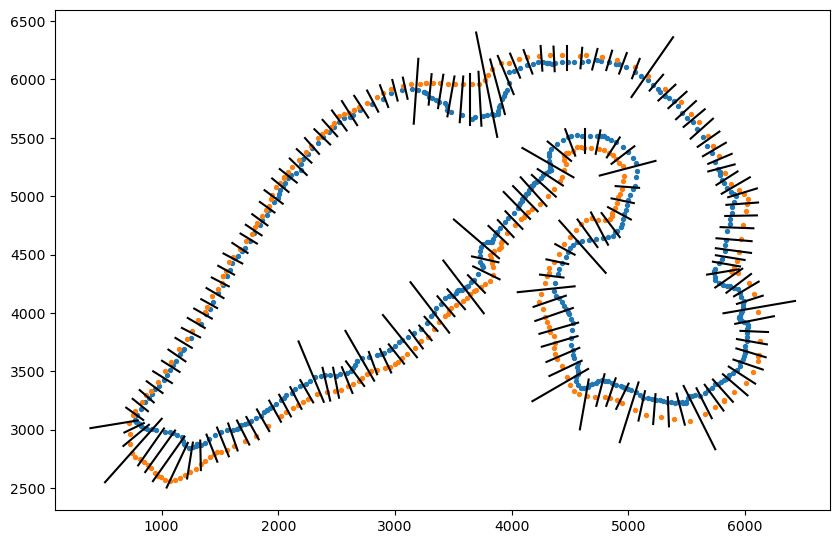

In [11]:
#Plot subdivision lines on ventricular zone outline
plt.figure(figsize=(10,10))
outer = pol_970_new[:289,:]
inner = pol_970_new[289:,:]
plt.scatter(inner[:,0], inner[:,1], s=8)
plt.scatter(outer[:,0], outer[:,1], s=8)

for ll in lines_970:
    plt.plot(ll[:,0], ll[:,1], c='k')
plt.gca().set_aspect('equal')

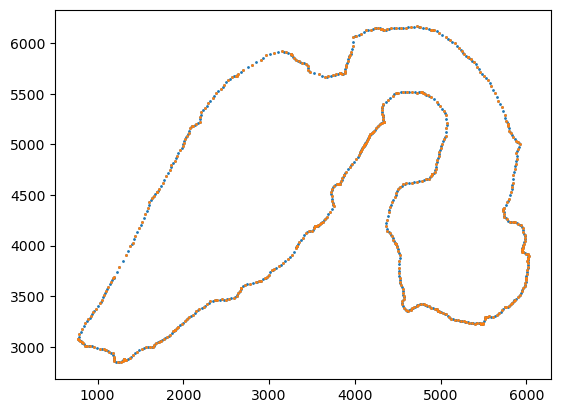

In [12]:
#Make the inner polygon more dens
inner_dense = []
for ii in sliding_window_view(inner, [2,2]):
    ii = ii[0]
    inner_dense.append(ii[0])
    mid = np.array(middle(ii[:,0], ii[:,1]))
    inner_dense.append(mid)
    
inner_dense = np.stack(inner_dense)

plt.figure()
plt.scatter(inner_dense[:,0], inner_dense[:,1], s=1)
plt.scatter(inner[:,0], inner[:,1], s=1)

2022-12-08 19:38:51,217 - INFO - Ring Self-intersection at or near point 1454.9913488934287 2793.0783932381346


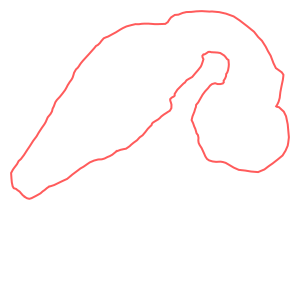

In [13]:
#Make a Shapely polygon out of `inner_dense`
pol = Polygon(outer, [inner_dense])
pol.exterior

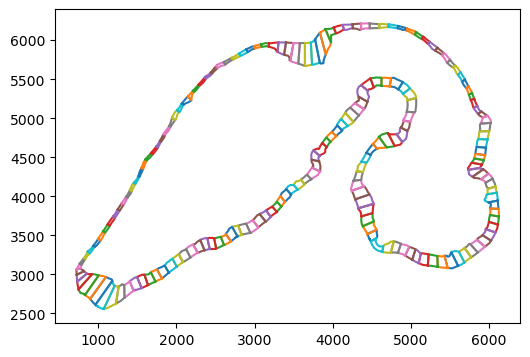

In [14]:
#Subdivide polygon

#Subdivision lines to use
lines = lines_970

#Make polygons that subdivide the brain
ls_list = [LineString(ll) for ll in lines]

# make a complex geometry
input_p = pol

#make list of lines as Shapely LineString
ls_list = [LineString(ll) for ll in lines]

# and a complex intersecting line
input_l = MultiLineString(ls_list)

# union the exterior lines of the polygon with the dividing linestring
unioned = input_p.boundary.union(input_l)

# use polygonize geos operator and filter out poygons ouside of origina input polygon
keep_polys = [poly for poly in polygonize(unioned) if poly.representative_point().within(input_p)]

# remaining polygons are the split polys of original shape
mp = MultiPolygon(keep_polys)

plt.figure(figsize=(6,6))
coord_dict = {}
for i, p in enumerate(mp.geoms):
    xy = p.exterior.coords.xy
    coord_dict[i] = np.stack(xy, axis=1)
    plt.plot(xy[0], xy[1])
    
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

#Area in um2
areas = []
for i in range(len(coord_dict)):
    xy = coord_dict[i]
    areas.append(PolyArea(xy[:,0], xy[:,1]))
plt.gca().set_aspect('equal')

In [15]:
#Count genes in polygons
df = pd.DataFrame(data=np.zeros((d970.unique_genes.shape[0], len(coord_dict))), index=d970.unique_genes)
df_gene = pd.DataFrame(data=d970.df.g, columns=['gene'])

points = d970.df.loc[:, ['x', 'y']].compute().to_numpy()
for l, filt in inside_simple_polygons(coord_dict, points):
    df.loc[d970.unique_genes, l] = df_gene[filt].groupby('gene').size()
del points

df = df.fillna(0)

df_raw = df.copy()

#Correct for area in mm2
df = df / (np.array(areas) / 1e6)

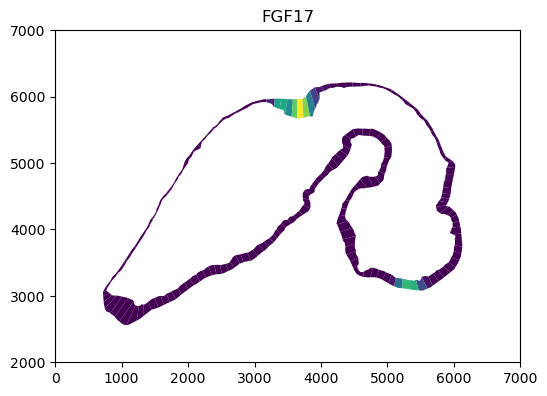

In [16]:
#Plot gene count example to inspect results
fig, ax = plt.subplots(figsize=(6,6))
g = 'FGF17'
col = df.loc[g, :]
col = col / col.max()
col = plt.cm.viridis(col)

for i in range(len(coord_dict)):
    xy = coord_dict[i]
    p = mplPolygon(xy, facecolor=col[i])
    ax.add_patch(p)
plt.xlim(0, 7000) 
plt.ylim(2000, 7000)
plt.title(g)
plt.gca().set_aspect('equal')

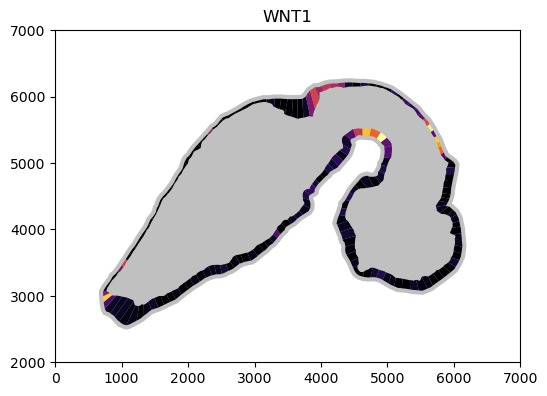

In [77]:
#Plot gene count example to inspect results
fig, ax = plt.subplots(figsize=(6,6))
g = 'WNT1'
col = df.loc[g, :]
col = col / col.max()
col = plt.cm.inferno(col)

p = mplPolygon(outer, linewidth=6, facecolor='silver', ec='silver')
ax.add_patch(p )

for i in range(len(coord_dict)):
    xy = coord_dict[i]
    p = mplPolygon(xy, facecolor=col[i])
    ax.add_patch(p)
plt.xlim(0, 7000) 
plt.ylim(2000, 7000)
plt.title(g)
plt.gca().set_aspect('equal')

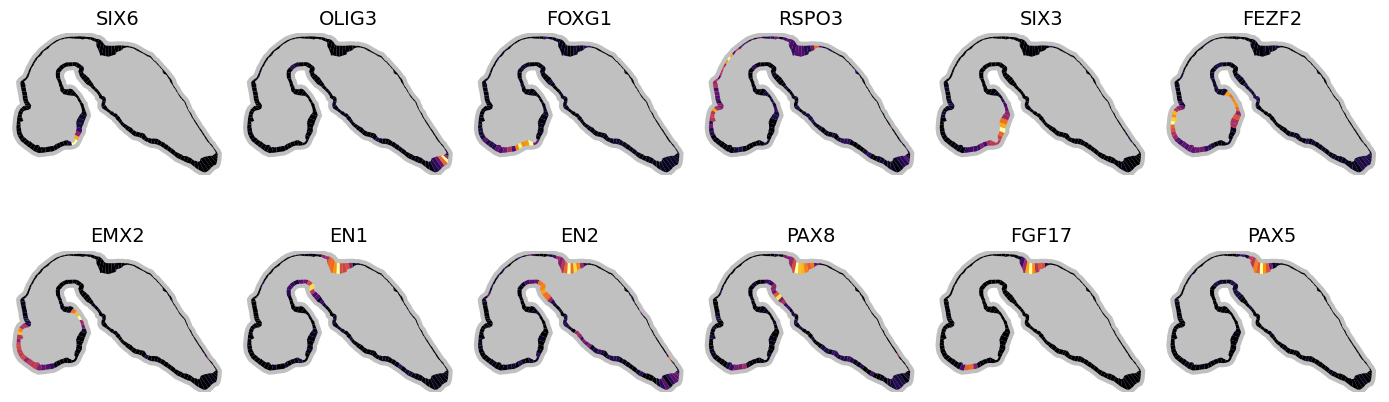

In [73]:
selected_genes = ['SIX6', 'OLIG3', 'FOXG1', 'RSPO3', 'SIX3','FEZF2', 'EMX2', 'EN1', 'EN2', 'PAX8', 'FGF17', 'PAX5']
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(14,5))

for i, g in enumerate(selected_genes):
    ax = axes[int(i/6), i%6]
    
    col = df.loc[g, :]
    col = col / col.max() #(col.max() + col.max() * 0.2)
    col = plt.cm.inferno(col)
    
    #Add background
    p = mplPolygon(outer, linewidth=6, facecolor='silver', ec='silver')
    ax.add_patch(p )

    for i in range(len(coord_dict)):
        xy = coord_dict[i]
        p = mplPolygon(xy, facecolor=col[i])
        ax.add_patch(p)
        
    ax.set_xlim(500, 6300) 
    ax.set_ylim(2500, 6300)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(g, fontsize=14)
    ax.invert_xaxis()
    
plt.tight_layout()
plt.savefig('results/examples_AP_patterning.pdf')

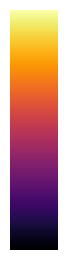

In [85]:
a = np.array([[0,1]])
plt.figure(figsize=(0.6, 4))
img = plt.imshow(a, cmap="inferno")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="vertical", cax=cax)
plt.axis('off')
plt.savefig("results/colorbar_inferno.pdf")

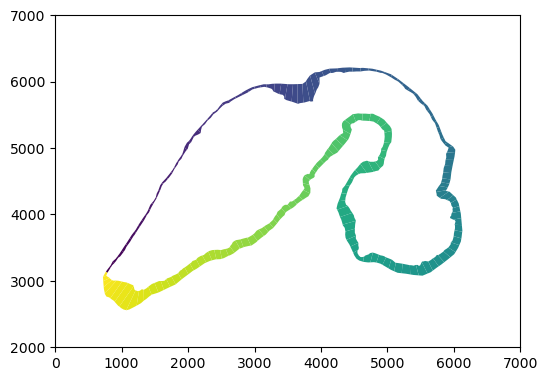

In [19]:
#Find the roll to have the start of the polygons somwhere else
fig, ax = plt.subplots(figsize=(6,6))

col = np.roll(df.columns, 77)
col = col / col.max()
col = plt.cm.viridis(col)

for i in range(len(coord_dict)):
    xy = coord_dict[i]
    p = mplPolygon(xy, facecolor=col[i])
    ax.add_patch(p)
plt.xlim(0, 7000) 
plt.ylim(2000, 7000)
plt.gca().set_aspect('equal')

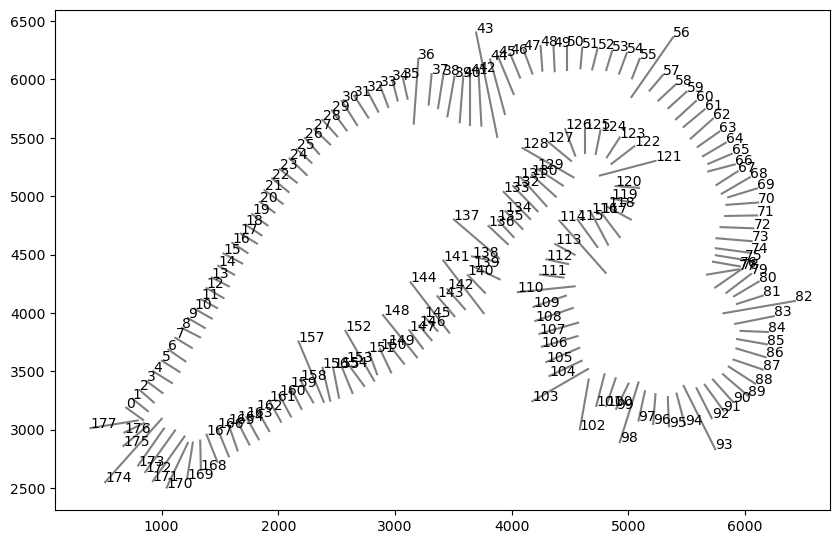

In [15]:
#Plot the new ordering numbers
plt.figure(figsize=(10,10))

for i, ll in enumerate(lines):
    plt.plot(ll[:,0], ll[:,1], c='gray')
    x, y = ll[1]
    plt.text(x, y, i)
    
    
plt.gca().set_aspect('equal')

In [16]:
border_col = ['#548F80', '#D648F2', '#61D23E',  '#53B039', '#FFE41B', '#C3313C', '#DF4927', '#E27A3A', '#804344', '#96623E', '#BB6C54', '#DBD06C',
             '#63AA54', '#9F49B5', '#AE5ACF', '#C274D8', '#6E38C5', '#7751C6', '#4784C6','#5D92C8','#4FAB95', '#548F80','#548F80']

(0.0, 7000.0, 2000.0, 7000.0)

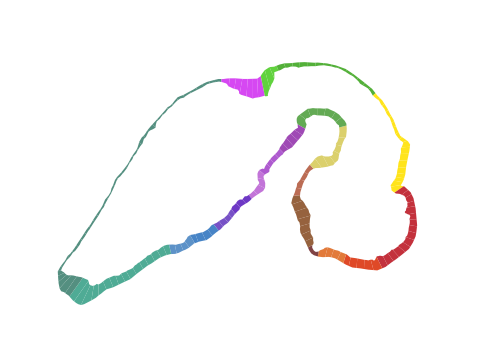

In [20]:
#Plot the colors of the polygons acording to the Allen brain atlas prosomeric model
fig, ax = plt.subplots(figsize=(6,6))

col_order = np.roll(df.columns, -77)

col = np.zeros(df.shape[1])
borders = [0, 36, 43, 46, 60, 78, 93, 98, 102, 103, 110, 114, 121, 128, 133, 137, 141, 144, 148, 152, 157, 174,  180] #177,
for i, view in enumerate(sliding_window_view(borders, 2)):
    col[view[0] : view[1]] = i/len(borders)

    
elin_polygon_colors = {'ROI_Pall': '#C3313C', 'ROI_Pall_VZ': '#C3313C','ROI_Pall_MZ': '#C74150', 'ROI_AM_CP': '#DF4927', 'ROI_AM_CP_VZ': '#DF4927', 
                  'ROI_AM_CP_MZ': '#FD6843',
'ROI_SPall': '#E27A3A','ROI_SPall_VZ': '#E27A3A', 'ROI_SPall_SVZ': '#E69D68','ROI_SPall_MZ': '#F2B880',
'ROI_THy': '#96623E','ROI_THy_VZ': '#96623E','ROI_THy_SVZ': '#A97751', 'ROI_THy_MZ': '#B2845B', 'ROI_optic_recess': '#9C5223','ROI_lamina_terminalis': '#804344',
'ROI_PHy': '#BB6C54','ROI_PHy_VZ': '#BB6C54','ROI_PHy_SVZ': '#C27D6A','ROI_PHy_MZ': '#D78A74',
'ROI_D_dorsal': '#FFE41B','ROI_D_dorsal_VZ': '#FFE41B','ROI_D_dorsal_MZ': '#FCF2B7','ROI_D_ventral': '#DBD06C','ROI_D_ventral_VZ': '#DBD06C',
                  'ROI_D_ventral_MZ': '#F1E177',
'ROI_MTt': '#53B039','ROI_MTg': '#63AA54','ROI_m2': '#61D23E','ROI_isthmus': '#D648F2',
'ROI_r1': '#9F49B5','ROI_r1_VZ': '#9F49B5','ROI_r1_MZ': '#C25BDC','ROI_r1-r2': '#AE5ACF','ROI_r1-r2_VZ': '#AE5ACF','ROI_r1-r2_SVZ': '#C75BDE',
                  'ROI_r1-r2_MZ': '#DB7CFA',
'ROI_r2_VZ': '#C274D8','ROI_r2_SVZ': '#D27EEC','ROI_r2_MZ': '#E5A1F9','ROI_r3_VZ': '#6E38C5','ROI_r3_SVZ': '#7C41DE','ROI_r3_MZ': '#9B61FA',
'ROI_r4_VZ': '#7751C6','ROI_r4_SVZ': '#875BE0','ROI_r4_MZ': '#A57BFF','ROI_r5_VZ': '#4784C6','ROI_r5_SVZ': '#4F94E0','ROI_r5_MZ': '#7EB8F3',
'ROI_r6_VZ': '#5D92C8','ROI_r6_SVZ': '#6AA4E1','ROI_r6_MZ': '#94C7F6','ROI_r7_VZ': '#4FAB95','ROI_r7_SVZ': '#59BFA7','ROI_r7_MZ': '#8CE0D0',
                  'ROI_r7_roof_plate': '#548F80','ROI_H_roof_plate': '#548F80'
}

border_col = ['#548F80', '#D648F2', '#61D23E',  '#53B039', '#FFE41B', '#C3313C', '#DF4927', '#E27A3A', '#804344', '#96623E', '#BB6C54', '#DBD06C',
             '#63AA54', '#9F49B5', '#AE5ACF', '#C274D8', '#6E38C5', '#7751C6', '#4784C6','#5D92C8','#4FAB95', '#548F80'] ##548F80',

border_col_arange = np.zeros(df.shape[1], dtype='object')
for i, view in enumerate(sliding_window_view(borders, 2, )):
    border_col_arange[view[0] : view[1]] = border_col[i]


for j,i in enumerate(col_order):
    xy = coord_dict[i]
    p = mplPolygon(xy, facecolor=border_col_arange[j])
    ax.add_patch(p)
plt.xlim(0, 7000) 
plt.ylim(2000, 7000)
plt.gca().set_aspect('equal')
plt.axis('off')
#plt.savefig('results/ABA_colors.pdf')

# Anterior - posterior patterning

In [21]:
#Split prosomers
n_anatomical_regions = len(border_col)
ref_spacing = np.array([36,  7,  3, 14, 18, 15,  5,  4,  1,  7,  4,  7,  7,  5,  4,  4,  3, 4,  4,  5, 17,  6]) #3
diff = np.ediff1d(borders)

x = []
x_cont = []
gap = 0
stop = 0
for r, d in zip(ref_spacing, diff):
    if d == 1:
        d=2
    start = stop + gap
    stop = start + r
    xi = np.linspace(start, stop, d)
    x.append(xi)
    x_cont.append(xi[:-1])
    gap = 0.7

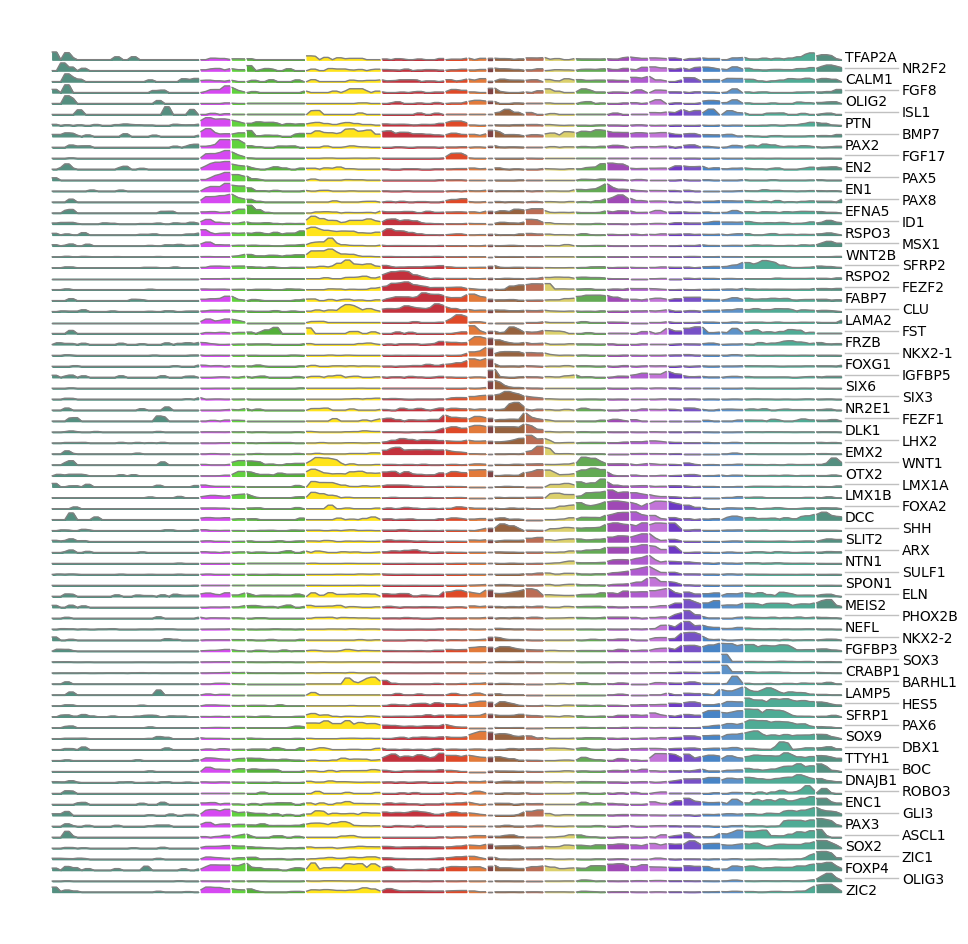

In [22]:
#Plot patterning histogram of relevant genes
plt.figure(figsize=(12, 12))

selected = ['ARX', 'ASCL1', 'BARHL1', 'BMP7', 'BOC', 'CALM1', 'CLU', 'CRABP1', 'DBX1', 'DCC', 'DLK1', 'DNAJB1', 'EFNA5', 'ELN', 'EMX2', 'EN1', 'EN2',
           'ENC1', 'FABP7', 'FEZF1', 'FEZF2', 'FGF8', 'FGF17', 'FGFBP3', 'FOXA2', 'FOXG1', 'FOXP4', 'FRZB', 'FST', 'GLI3', 'HES5', 'ID1', 'IGFBP5',
           'ISL1', 'LAMA2', 'LAMP5', 'LHX2', 'LMX1A', 'LMX1B', 'MEIS2', 'MSX1','NEFL', 'NKX2-1', 'NKX2-2', 'NR2E1', 'NR2F2', 'NTN1', 'OLIG2', 'OLIG3',
           'OTX2', 'PAX2', 'PAX3', 'PAX5', 'PAX6', 'PAX8', 'PHOX2B', 'PTN', 'ROBO3', 'RSPO2', 'RSPO3', 'SFRP1', 'SFRP2', 'SHH', 'SIX3', 'SIX6', 'SLIT2',
           'SOX2', 'SOX3', 'SOX9', 'SPON1', 'SULF1', 'TFAP2A', 'TTYH1', 'WNT1', 'WNT2B', 'ZIC1', 'ZIC2']

filt = np.isin(df.index, selected)
ap = df.loc[filt]
selected_order = ap.index
ap = np.roll(ap.to_numpy(), -77, axis=1)
sort = np.argsort(np.argmax(ap, axis=1))
selected_order = selected_order[sort]

for y, g in enumerate(selected_order[::-1]):
    
    data = df.loc[g, col_order].to_numpy()
    data = median_filter(data, footprint=np.ones(2))
    data[data<0] = 0
    data = (data / data.max()) * 0.7
    data2 = data
    data = np.split(data, borders[1:])

    for i, (xi, d) in enumerate(zip(x, data)):
        plt.fill_between(xi, y, y+d, color=border_col[i])
        if len(d) == 1:
            d = np.array([d, d])
        plt.plot(xi, y+d, c='gray', linewidth=1)
    if y % 2 == 1:
        plt.plot([xi[-1]+1, xi[-1]+14], [y+0.25, y+0.25], c='silver', linewidth=1)
        plt.text(xi[-1]+15, y-0.25, g)
    else:
        plt.text(xi[-1]+1, y-0.25, g)
    
plt.axis('off');
#plt.savefig('results/Patterning_970.pdf')

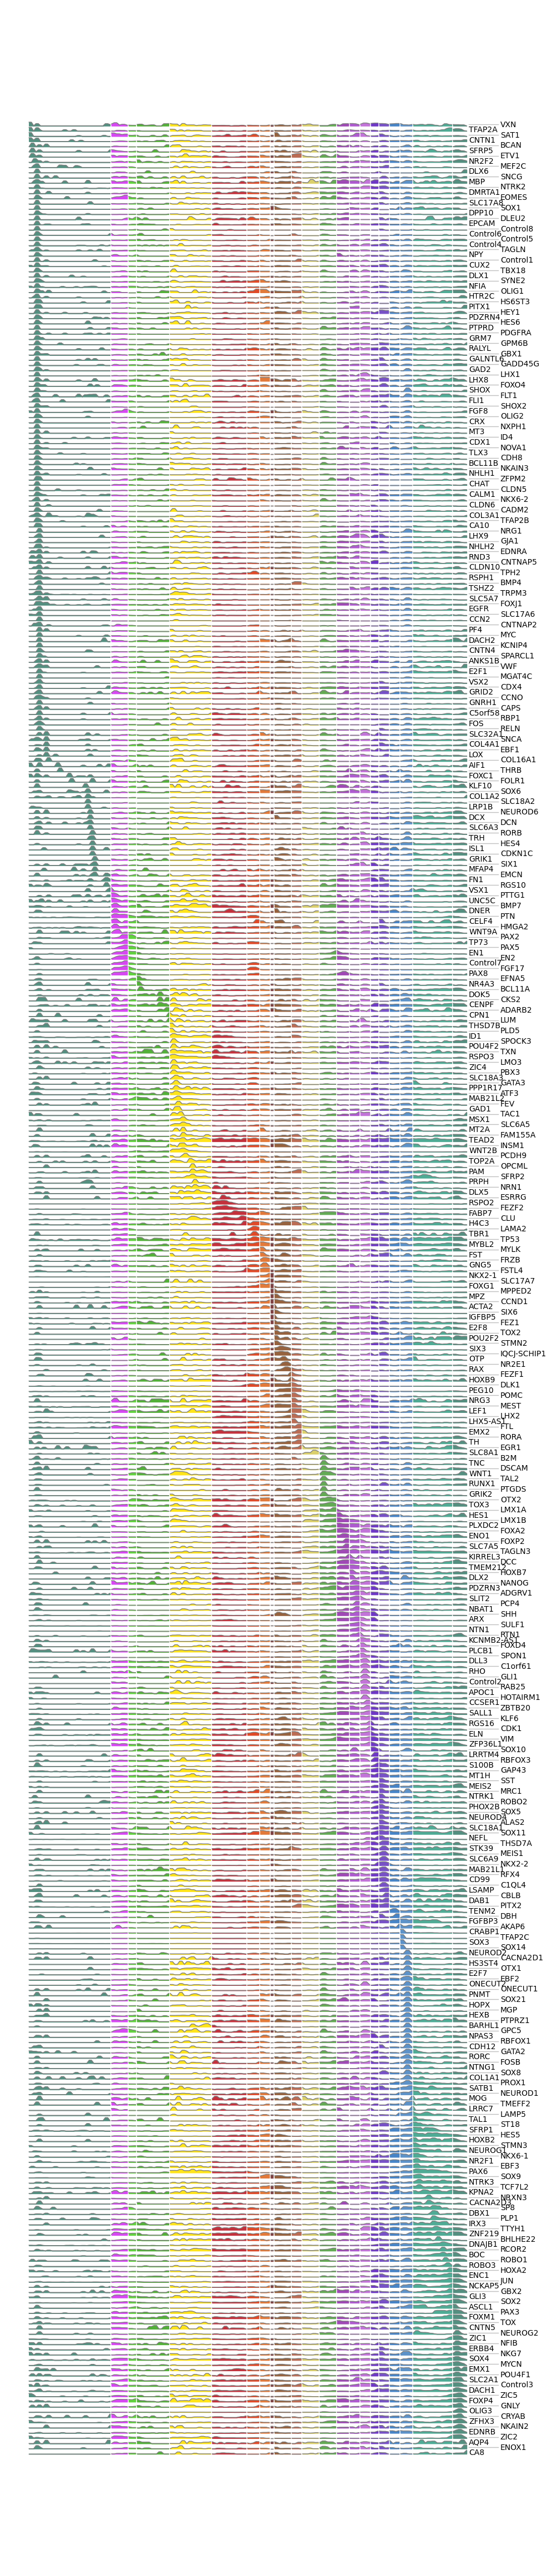

In [24]:
#Plot all genes
#Note that some genes are lowly expressed but due to normaization to their maximum they look equal to other genes.
#Always check raw gene expression to see if results are relevant.
plt.figure(figsize=(12, 12*5))

selected = d970.unique_genes

filt = np.isin(df.index, selected)
ap = df.loc[filt]
selected_order = ap.index
ap = np.roll(ap.to_numpy(), -77, axis=1)
sort = np.argsort(np.argmax(ap, axis=1))
selected_order = selected_order[sort]

for y, g in enumerate(selected_order[::-1]):
    
    data = df.loc[g, col_order].to_numpy()
    data = median_filter(data, footprint=np.ones(2))
    data[data<0] = 0
    #Normalization
    data = (data / data.max()) * 0.7
    data2 = data
    data = np.split(data, borders[1:])

    for i, (xi, d) in enumerate(zip(x, data)):
        plt.fill_between(xi, y, y+d, color=border_col[i])
        if len(d) == 1:
            d = np.array([d, d])
        plt.plot(xi, y+d, c='gray', linewidth=1)
    if y % 2 == 1:
        plt.plot([xi[-1]+1, xi[-1]+14], [y+0.25, y+0.25], c='silver', linewidth=1)
        plt.text(xi[-1]+15, y-0.25, g)
    else:
        plt.text(xi[-1]+1, y-0.25, g)
    
plt.axis('off');